<a href="https://colab.research.google.com/github/xili5979/CS61-1/blob/main/%E2%80%9CModel_test1_V6_0_for_lee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import**

In [3]:
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt
import re

from numpy.random import seed
seed(101)
# from tensorflow import set_random_seed
# set_random_seed(101)
import os, cv2
import pandas as pd
import numpy as np
#import keras
#from keras import backend as K
from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [ ]:
# 
# shutil.rmtree("/content/HAM10000_images_part_1")

GPU

In [132]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [133]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 19 16:08:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    40W / 300W |    425MiB / 16160MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Load DATA**

## **Load img**

In [76]:
!unzip '/content/drive/MyDrive/5703File/DataSet/dataverse_files/ISIC_2019_Training_Input.zip' -d '/content/ISIC_2019_Training_Input/'

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065357.jpg  
  inflating: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065358.jpg  
  inflating: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065359.jpg  
  inflating: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065360.jpg  
  inflating: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065361.jpg  
  inflating: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065362.jpg  
  inflating: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065366.jpg  
  inflating: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065367.jpg  
  inflating: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065368.jpg  
  inflating: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065370.jpg  
  inflating: /content/ISIC_2019_Training_Input/ISIC_2019_Traini

25331


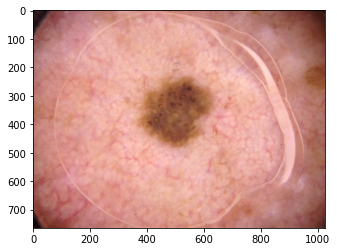

In [80]:
image_part1 = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
# image_part2 =  '/content/HAM10000_images_part_2'
images1 = glob("/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/*.jpg")
# images2 = glob("/content/HAM10000_images_part_2/*.jpg")
# all_images = images1+images2
print(len(images1))
image0 = cv2.imread(images1[777])
plt.imshow(image0[:,:,::-1])

## **Load CSV**

First dataset csv

In [ ]:
df = pd.read_csv ('/content/drive/MyDrive/5703File/DataSet/dataverse_files/HAM10000_metadata')
print(df)

         lesion_id      image_id     dx  ...     sex  localization       dataset
0      HAM_0000118  ISIC_0027419    bkl  ...    male         scalp  vidir_modern
1      HAM_0000118  ISIC_0025030    bkl  ...    male         scalp  vidir_modern
2      HAM_0002730  ISIC_0026769    bkl  ...    male         scalp  vidir_modern
3      HAM_0002730  ISIC_0025661    bkl  ...    male         scalp  vidir_modern
4      HAM_0001466  ISIC_0031633    bkl  ...    male           ear  vidir_modern
...            ...           ...    ...  ...     ...           ...           ...
10010  HAM_0002867  ISIC_0033084  akiec  ...    male       abdomen  vidir_modern
10011  HAM_0002867  ISIC_0033550  akiec  ...    male       abdomen  vidir_modern
10012  HAM_0002867  ISIC_0033536  akiec  ...    male       abdomen  vidir_modern
10013  HAM_0000239  ISIC_0032854  akiec  ...    male          face  vidir_modern
10014  HAM_0003521  ISIC_0032258    mel  ...  female          back  vidir_modern

[10015 rows x 8 columns]


In [ ]:
d_type = list(df.dx)
set(d_type)

{'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'}

In [ ]:
print("akiec: %d" %d_type.count('akiec'))
print("bcc: %d" %d_type.count('bcc'))
print("bkl: %d" %d_type.count('bkl'))
print("df: %d" %d_type.count('df'))
print("mel: %d" %d_type.count('mel'))
print("nv: %d" %d_type.count('nv'))
print("vasc: %d" %d_type.count('vasc'))

akiec: 327
bcc: 514
bkl: 1099
df: 115
mel: 1113
nv: 6705
vasc: 142


## Second dataset csv ISIC 2019

In [81]:
#ISIC2019
df_2019 = pd.read_csv ('/content/drive/MyDrive/5703File/DataSet/dataverse_files/ISIC_2019_Training_GroundTruth.csv')
print(df_2019)

              image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0      ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1      ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2      ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3      ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4      ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
...             ...  ...  ...  ...  ...  ...  ...   ...  ...  ...
25326  ISIC_0073247  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0
25327  ISIC_0073248  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0
25328  ISIC_0073249  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25329  ISIC_0073251  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25330  ISIC_0073254  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0

[25331 rows x 10 columns]


In [82]:
df_Metadata = pd.read_csv("/content/drive/MyDrive/5703File/DataSet/dataverse_files/ISIC_2019_Training_Metadata.csv")
print(df_Metadata)

              image  age_approx anatom_site_general    lesion_id     sex
0      ISIC_0000000        55.0      anterior torso          NaN  female
1      ISIC_0000001        30.0      anterior torso          NaN  female
2      ISIC_0000002        60.0     upper extremity          NaN  female
3      ISIC_0000003        30.0     upper extremity          NaN    male
4      ISIC_0000004        80.0     posterior torso          NaN    male
...             ...         ...                 ...          ...     ...
25326  ISIC_0073247        85.0           head/neck  BCN_0003925  female
25327  ISIC_0073248        65.0      anterior torso  BCN_0001819    male
25328  ISIC_0073249        70.0     lower extremity  BCN_0001085    male
25329  ISIC_0073251        55.0         palms/soles  BCN_0002083  female
25330  ISIC_0073254        50.0     upper extremity  BCN_0001079    male

[25331 rows x 5 columns]


In [83]:
df_2019['lesion_id'] = df_Metadata['lesion_id']

In [84]:
# create a new colum that is a copy of the lesion_id column
df_2019['dx'] = '0'

In [85]:
df_2019.loc[df_2019['MEL']== 1 ,'dx'] = 'mel'
df_2019.loc[df_2019['NV']== 1 ,'dx'] = 'nv'
df_2019.loc[df_2019['BCC']== 1 ,'dx'] = 'bcc'
df_2019.loc[df_2019['AK']== 1 ,'dx'] = 'akiec'
df_2019.loc[df_2019['BKL']== 1 ,'dx'] = 'bkl'
df_2019.loc[df_2019['DF']== 1 ,'dx'] = 'df'
df_2019.loc[df_2019['VASC']== 1 ,'dx'] = 'vasc'
df_2019.loc[df_2019['SCC']== 1 ,'dx'] = 'scc'
df_2019.loc[df_2019['UNK']== 1 ,'dx'] = 'unk'

In [86]:
df_2019_clear=df_2019.dropna(subset=['lesion_id'])

In [87]:
print(df_2019_clear)

                          image  MEL   NV  BCC  ...  SCC  UNK     lesion_id   dx
1459   ISIC_0012653_downsampled  0.0  1.0  0.0  ...  0.0  0.0  MSK4_0011169   nv
1460   ISIC_0012654_downsampled  0.0  1.0  0.0  ...  0.0  0.0  MSK4_0011170   nv
1461   ISIC_0012655_downsampled  0.0  1.0  0.0  ...  0.0  0.0  MSK4_0011171   nv
1462   ISIC_0012656_downsampled  0.0  1.0  0.0  ...  0.0  0.0  MSK4_0011172   nv
1463   ISIC_0012657_downsampled  0.0  1.0  0.0  ...  0.0  0.0  MSK4_0011173   nv
...                         ...  ...  ...  ...  ...  ...  ...           ...  ...
25326              ISIC_0073247  0.0  0.0  1.0  ...  0.0  0.0   BCN_0003925  bcc
25327              ISIC_0073248  0.0  0.0  0.0  ...  0.0  0.0   BCN_0001819  bkl
25328              ISIC_0073249  1.0  0.0  0.0  ...  0.0  0.0   BCN_0001085  mel
25329              ISIC_0073251  0.0  1.0  0.0  ...  0.0  0.0   BCN_0002083   nv
25330              ISIC_0073254  0.0  0.0  0.0  ...  0.0  0.0   BCN_0001079  bkl

[23247 rows x 12 columns]


In [88]:
print(df_2019_clear['dx'].value_counts())

nv       11326
mel       4185
bcc       3323
bkl       2426
akiec      867
scc        628
vasc       253
df         239
Name: dx, dtype: int64


Delete some nv to 4000

In [89]:
indexNames_nv = df_2019_clear[(df_2019_clear['dx'] == 'nv')].index
df_2019_clear.drop(indexNames_nv[:(indexNames_nv.shape[0]-4000)] , inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [90]:
print(df_2019_clear['dx'].value_counts())

mel      4185
nv       4000
bcc      3323
bkl      2426
akiec     867
scc       628
vasc      253
df        239
Name: dx, dtype: int64


## ISIC 2020 df

In [15]:
#ISIC2020
df_2020 = pd.read_csv ('/content/drive/MyDrive/5703File/DataSet/dataverse_files/ISIC2020/ISIC_2020_Training_GroundTruth (1).csv')
print(df_2020)

         image_name  patient_id     sex  ...  diagnosis benign_malignant target
0      ISIC_2637011  IP_7279968    male  ...    unknown           benign      0
1      ISIC_0015719  IP_3075186  female  ...    unknown           benign      0
2      ISIC_0052212  IP_2842074  female  ...      nevus           benign      0
3      ISIC_0068279  IP_6890425  female  ...    unknown           benign      0
4      ISIC_0074268  IP_8723313  female  ...    unknown           benign      0
...             ...         ...     ...  ...        ...              ...    ...
33121  ISIC_9999134  IP_6526534    male  ...    unknown           benign      0
33122  ISIC_9999320  IP_3650745    male  ...    unknown           benign      0
33123  ISIC_9999515  IP_2026598    male  ...    unknown           benign      0
33124  ISIC_9999666  IP_7702038    male  ...    unknown           benign      0
33125  ISIC_9999806  IP_0046310    male  ...      nevus           benign      0

[33126 rows x 8 columns]


In [16]:
#show classes
print(df_2020['diagnosis'].value_counts())

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64


#**CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS**
## Dont run again

In [91]:
# Create a new directory
base_dir = '/content/base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 7 folders inside 'base_dir':

# train_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df
    #scc
 
# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df
    #scc

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)
scc = os.path.join(train_dir, 'scc')
os.mkdir(scc)


# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)
scc = os.path.join(val_dir, 'scc')
os.mkdir(scc)

# **Train，validation**

In [93]:
df_data =df_2019_clear

In [94]:
# df_data = pd.read_csv ('/content/drive/MyDrive/5703File/DataSet/dataverse_files/HAM10000_metadata')
df_data.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion_id,dx
1467,ISIC_0012661_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011175,bkl
1472,ISIC_0012666_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011180,bkl
1482,ISIC_0012678_downsampled,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MSK4_0010037,mel
1492,ISIC_0012693_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011202,bkl
1493,ISIC_0012696_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011205,bkl


In [95]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

In [96]:
df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,dx
lesion_id,,,,,,,,,,,
BCN_0000001,3,3,3,3,3,3,3,3,3,3,3
BCN_0000002,3,3,3,3,3,3,3,3,3,3,3
BCN_0000003,2,2,2,2,2,2,2,2,2,2,2
BCN_0000004,6,6,6,6,6,6,6,6,6,6,6
BCN_0000008,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...
MSK4_0012018,1,1,1,1,1,1,1,1,1,1,1
MSK4_0012023,1,1,1,1,1,1,1,1,1,1,1
MSK4_0012036,1,1,1,1,1,1,1,1,1,1,1


In [98]:
# now we filter out lesion_id's that have only one image associated with it
df = df[df['image'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,dx
0,BCN_0000013,1,1,1,1,1,1,1,1,1,1,1
1,BCN_0000020,1,1,1,1,1,1,1,1,1,1,1
2,BCN_0000039,1,1,1,1,1,1,1,1,1,1,1
3,BCN_0000053,1,1,1,1,1,1,1,1,1,1,1
4,BCN_0000059,1,1,1,1,1,1,1,1,1,1,1


In [99]:
# here we identify lesion_id's that have duplicate images and those that have only one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion_id,dx,duplicates
1467,ISIC_0012661_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011175,bkl,no_duplicates
1472,ISIC_0012666_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011180,bkl,no_duplicates
1482,ISIC_0012678_downsampled,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MSK4_0010037,mel,no_duplicates
1492,ISIC_0012693_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011202,bkl,no_duplicates
1493,ISIC_0012696_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011205,bkl,no_duplicates


In [100]:
df_data['duplicates'].value_counts()

has_duplicates    13921
no_duplicates      2000
Name: duplicates, dtype: int64

In [106]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.50, random_state=101, stratify=y)

# df_val.shape
# _, df = train_test_split(df, test_size=0.99, random_state=100, stratify=y)
df_val.shape

(1000, 13)

In [ ]:
# indexNames_nv = df[(df['dx'] == 'nv')].index
# indexNames_mel = df[(df['dx'] == 'mel')].index
# indexNames_bkl = df[(df['dx'] == 'bkl')].index
# indexNames_bcc = df[(df['dx'] == 'bcc')].index
# indexNames_akiec = df[(df['dx'] == 'akiec')].index
# indexNames_vasc = df[(df['dx'] == 'vasc')].index
# indexNames_df = df[(df['dx'] == 'df')].index

# df.drop(indexNames_nv[:(indexNames_nv.shape[0]-50)] , inplace=True)
# df.drop(indexNames_mel[:(indexNames_mel.shape[0]-50)] , inplace=True)
# df.drop(indexNames_bkl[:(indexNames_bkl.shape[0]-50)] , inplace=True)
# df.drop(indexNames_bcc[:(indexNames_bcc.shape[0]-50)] , inplace=True)
# df.drop(indexNames_akiec[:(indexNames_akiec.shape[0]-50)] , inplace=True)
# df.drop(indexNames_vasc[:(indexNames_vasc.shape[0]-20)] , inplace=True)
# df.drop(indexNames_df[:(indexNames_df.shape[0]-20)] , inplace=True)

In [ ]:
# df_val = df

In [107]:
df_val['dx'].value_counts()

bkl      346
mel      223
bcc      183
nv        94
scc       55
akiec     41
vasc      36
df        22
Name: dx, dtype: int64

### **Create a train set that excludes images that are in the val set**

In [110]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


14921
1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-------------------------------

In [111]:
# indexNames_nv = df_train[(df_train['dx'] == 'nv')].index
# indexNames_mel = df_train[(df_train['dx'] == 'mel')].index
# indexNames_bkl = df_train[(df_train['dx'] == 'bkl')].index

# df_train.drop(indexNames_nv[:(indexNames_nv.shape[0]-2000)] , inplace=True)
# df_train.drop(indexNames_mel[:(indexNames_mel.shape[0]-500)] , inplace=True)
# df_train.drop(indexNames_bkl[:(indexNames_bkl.shape[0]-500)] , inplace=True)

------------------------------------------

In [112]:
df_train['dx'].value_counts()

mel      3962
nv       3906
bcc      3140
bkl      2080
akiec     826
scc       573
df        217
vasc      217
Name: dx, dtype: int64

In [113]:
df_val['dx'].value_counts()

bkl      346
mel      223
bcc      183
nv        94
scc       55
akiec     41
vasc      36
df        22
Name: dx, dtype: int64

### **Transfer the Images into the Folders**

In [115]:
# Set the image_id as the index in df_data
df_data.set_index('image', inplace=True)

In [116]:
df_data

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion_id,dx,duplicates,train_or_val
image,,,,,,,,,,,,,
ISIC_0012661_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011175,bkl,no_duplicates,train
ISIC_0012666_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011180,bkl,no_duplicates,train
ISIC_0012678_downsampled,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MSK4_0010037,mel,no_duplicates,train
ISIC_0012693_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011202,bkl,no_duplicates,train
ISIC_0012696_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011205,bkl,no_duplicates,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCN_0003925,bcc,has_duplicates,train
ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BCN_0001819,bkl,has_duplicates,train
ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BCN_0001085,mel,has_duplicates,train


In [118]:
# Get a list of images in each of the two folders
folder_1 = os.listdir(image_part1)
# folder_2 = os.listdir(image_part2)

# Get a list of train and val images
train_images = list(df_train.image)
train_labels = list(df_train.dx)
validation_images = list(df_val.image)
validation_labels = list(df_val.dx)


In [119]:
df_train

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion_id,dx,duplicates,train_or_val
1467,ISIC_0012661_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011175,bkl,no_duplicates,train
1472,ISIC_0012666_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011180,bkl,no_duplicates,train
1482,ISIC_0012678_downsampled,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MSK4_0010037,mel,no_duplicates,train
1492,ISIC_0012693_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011202,bkl,no_duplicates,train
1493,ISIC_0012696_downsampled,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MSK4_0011205,bkl,no_duplicates,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCN_0003925,bcc,has_duplicates,train
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BCN_0001819,bkl,has_duplicates,train
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BCN_0001085,mel,has_duplicates,train
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BCN_0002083,nv,has_duplicates,train


In [120]:
# Transfer the train images

for image in tqdm(train_images):
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(image_part1, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in tqdm(validation_images):
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(image_part1, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


100%|██████████| 1000/1000 [00:13<00:00, 74.79it/s]


In [123]:
print(len(os.listdir('/content/base_dir/train_dir/nv')))
print(len(os.listdir('/content/base_dir/train_dir/mel')))
print(len(os.listdir('/content/base_dir/train_dir/bkl')))
print(len(os.listdir('/content/base_dir/train_dir/scc')))
print(len(os.listdir('/content/base_dir/train_dir/bcc')))
print(len(os.listdir('/content/base_dir/train_dir/akiec')))
print(len(os.listdir('/content/base_dir/train_dir/vasc')))
print(len(os.listdir('/content/base_dir/train_dir/df')))

3906
3962
2080
573
3140
826
217
217


In [124]:
print(len(os.listdir('/content/base_dir/val_dir/nv')))
print(len(os.listdir('/content/base_dir/val_dir/mel')))
print(len(os.listdir('/content/base_dir/val_dir/bkl')))
print(len(os.listdir('/content/base_dir/val_dir/scc')))
print(len(os.listdir('/content/base_dir/val_dir/bcc')))
print(len(os.listdir('/content/base_dir/val_dir/akiec')))
print(len(os.listdir('/content/base_dir/val_dir/vasc')))
print(len(os.listdir('/content/base_dir/val_dir/df')))

94
223
346
55
183
41
36
22


## **Copy the train images into aug_dir**

In [125]:
# note that we are not augmenting class 'nv'
class_list = ['nv','mel','bkl','bcc','akiec','vasc','df','scc']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('/content/base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('/content/base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = '/content/base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 3906 images belonging to 1 classes.
Found 3962 images belonging to 1 classes.
Found 2080 images belonging to 1 classes.
Found 3140 images belonging to 1 classes.
Found 826 images belonging to 1 classes.
Found 217 images belonging to 1 classes.
Found 217 images belonging to 1 classes.
Found 573 images belonging to 1 classes.


In [126]:
print(len(os.listdir('/content/base_dir/train_dir/nv')))
print(len(os.listdir('/content/base_dir/train_dir/mel')))
print(len(os.listdir('/content/base_dir/train_dir/bkl')))
print(len(os.listdir('/content/base_dir/train_dir/scc')))
print(len(os.listdir('/content/base_dir/train_dir/bcc')))
print(len(os.listdir('/content/base_dir/train_dir/akiec')))
print(len(os.listdir('/content/base_dir/train_dir/vasc')))
print(len(os.listdir('/content/base_dir/train_dir/df')))

6006
6012
6010
5780
6040
5882
5258
5258


In [127]:
print(len(os.listdir('/content/base_dir/val_dir/nv')))
print(len(os.listdir('/content/base_dir/val_dir/mel')))
print(len(os.listdir('/content/base_dir/val_dir/bkl')))
print(len(os.listdir('/content/base_dir/val_dir/scc')))
print(len(os.listdir('/content/base_dir/val_dir/bcc')))
print(len(os.listdir('/content/base_dir/val_dir/akiec')))
print(len(os.listdir('/content/base_dir/val_dir/vasc')))
print(len(os.listdir('/content/base_dir/val_dir/df')))

94
223
346
55
183
41
36
22


### **Put the data to content**

# **Model Building**

## **Train the model**

In [128]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)
  


# **Evaluate the model using the val set**

## **Create a Confusion Matrix**

In [129]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# **Xception**

In [135]:
def Xception_structure(image_height,image_width,es_patience,lr_patience,min_learningrate,epochs_num):
  train_path = '/content/base_dir/train_dir'
  valid_path = '/content/base_dir/val_dir'

  num_train_samples = len(df_train)
  num_val_samples = len(df_val)
  train_batch_size = 10
  val_batch_size = 10
  # image_height = 225
  # image_width = 300

  train_steps = np.ceil(num_train_samples / train_batch_size)
  val_steps = np.ceil(num_val_samples / val_batch_size)

  ####################################################################
  datagen = ImageDataGenerator(
      preprocessing_function= \
      tf.keras.applications.xception.preprocess_input)

  train_batches = datagen.flow_from_directory(train_path,
                                              target_size=(image_height,image_width),
                                              batch_size=train_batch_size)

  valid_batches = datagen.flow_from_directory(valid_path,
                                              target_size=(image_height,image_width),
                                              batch_size=val_batch_size)

  # Note: shuffle=False causes the test dataset to not be shuffled
  test_batches = datagen.flow_from_directory(valid_path,
                                              target_size=(image_height,image_width),
                                              batch_size=1,
                                              shuffle=False)
  #####################################################################
  # create a copy of a mobilenet model
  model_X = tf.keras.applications.xception.Xception()
  # model_X.summary()
  # CREATE THE MODEL ARCHITECTURE

  # This will include all layers up to and including global_average_pooling2d_1
  x = model_X.layers[-2].output

  # Create a new dense layer for predictions
  # 7 corresponds to the number of classes
  x = Dropout(0.25)(x)
  predictions = Dense(8, activation='softmax')(x)

  # inputs=mobile.input selects the input layer, outputs=predictions refers to the dense layer we created above.

  model_X = Model(inputs=model_X.input, outputs=predictions)

  # model_X.summary()
  #######################################################################
  # Get the labels that are associated with each index
  print(valid_batches.class_indices)
#   {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'scc': 6, 'vasc': 7}

  # Add weights to try to make the model more sensitive to melanoma

  class_weights={
      0: 1.0, # akiec
      1: 1.0, # bcc
      2: 1.0, # bkl
      3: 1.0, # df
      4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
      5: 1.0, # nv
      6: 1.0, # scc
      7: 1.0, # vasc
  }
  #######################################################################
  model_X.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', 
                metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

  filepath = "model_X.h5" #inceptionV3
  checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                              save_best_only=True, mode='max')

  es_callback = tf.keras.callbacks.EarlyStopping(patience=es_patience, 
                                                verbose=1, 
                                                restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=lr_patience, 
                                    verbose=1, mode='max', min_lr=min_learningrate)
                                
                                
  callbacks_list = [es_callback,checkpoint, reduce_lr]

  history = model_X.fit(train_batches, steps_per_epoch=train_steps, 
                                class_weight=class_weights,
                      validation_data=valid_batches,
                      validation_steps=val_steps,
                      epochs=epochs_num, verbose=1,
                    callbacks=callbacks_list)
  ######################################################################### Evaluation
  #Draw loss figure
  # get the metric names so we can use evaulate_generator
  model_X.metrics_names

  # Here the the last epoch will be used.

  val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
  model_X.evaluate_generator(test_batches, 
                          steps=len(df_val))

  print('val_loss:', val_loss)
  print('val_cat_acc:', val_cat_acc)
  print('val_top_2_acc:', val_top_2_acc)
  print('val_top_3_acc:', val_top_3_acc)

  # Here the best epoch will be used.

  model_X.load_weights('model_X.h5')

  val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
  model_X.evaluate_generator(test_batches, 
                          steps=len(df_val))

  print('val_loss:', val_loss)
  print('val_cat_acc:', val_cat_acc)
  print('val_top_2_acc:', val_top_2_acc)
  print('val_top_3_acc:', val_top_3_acc)


  # display the loss and accuracy curves

  import matplotlib.pyplot as plt

  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_top2_acc = history.history['top_2_accuracy']
  val_top2_acc = history.history['val_top_2_accuracy']
  train_top3_acc = history.history['top_3_accuracy']
  val_top3_acc = history.history['val_top_3_accuracy']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.figure()

  plt.plot(epochs, acc, 'bo', label='Training cat acc')
  plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
  plt.title('Training and validation cat accuracy')
  plt.legend()
  plt.figure()


  plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
  plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
  plt.title('Training and validation top2 accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
  plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
  plt.title('Training and validation top3 accuracy')
  plt.legend()


  plt.show()
  ######################################################################### Evaluation
  #Draw Confusion matrix

  # Get the labels of the test images.

  test_labels = test_batches.classes
  # We need these to plot the confusion matrix.
  test_labels

  # Print the label associated with each class
  test_batches.class_indices

  # make a prediction
  predictions = model_X.predict_generator(test_batches, steps=len(df_val), verbose=1)

  test_labels.shape
  # argmax returns the index of the max value in a row
  cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
  print(test_batches.class_indices)

  # Define the labels of the class indices. These need to match the 
  # order shown above.
  cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv','scc', 'vasc']

  plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
  ######################################################################### Evaluation
  # Get report
  # Get the index of the class with the highest probability score
  y_pred = np.argmax(predictions, axis=1)

  # Get the labels of the test images.
  y_true = test_batches.classes

  from sklearn.metrics import classification_report

  # Generate a classification report
  report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

  print(report)
  ######################################################################### Evaluation
  #Draw AUC
#   from sklearn import metrics
#   from itertools import chain
#   def f(i):
#     l = [0, 0, 0, 0, 0, 0, 0]
#     l[i] = 1
#     return l
#   #计算
#   y_pre = list(map(f,test_batches.classes))
#   y = sum(y_pre,[])
#   scores = list(chain.from_iterable(predictions))

#   fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)

#   from sklearn.metrics import auc 
#   metrics.auc(fpr, tpr) 
#   auc = metrics.auc(fpr, tpr)
#   #image drawing
#   plt.plot(fpr, tpr, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % auc)
#   plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
#   plt.xlim((-0.01, 1.02))
#   plt.ylim((-0.01, 1.02))
#   plt.xticks(np.arange(0, 1.1, 0.1))
#   plt.yticks(np.arange(0, 1.1, 0.1))
#   plt.xlabel('False Positive Rate', fontsize=13)
#   plt.ylabel('True Positive Rate', fontsize=13)
#   plt.grid(b=True, ls=':')
#   plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
#   plt.title(u'EfficientB0', fontsize=17)
#   plt.show()

#   # 引入必要的库
#   import matplotlib.pyplot as plt
#   from itertools import cycle
#   from sklearn import svm, datasets
#   from sklearn.metrics import roc_curve, auc
#   from sklearn.model_selection import train_test_split
#   from sklearn.preprocessing import label_binarize
#   from sklearn.multiclass import OneVsRestClassifier
#   from scipy import interp

#   yscore = predictions.tolist()


#   # 计算每一类的ROC
#   fpr = dict()
#   tpr = dict()
#   roc_auc = dict()
#   for i in range(len(cm_plot_labels)):
#       fpr[i], tpr[i], thresholds = metrics.roc_curve([m[i] for m in y_pre], [n[i] for n in yscore], pos_label=1)
#       roc_auc[i] = auc(fpr[i], tpr[i])

#   # Compute macro-average ROC curve and ROC area（方法一）
#   # First aggregate all false positive rates
#   all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(cm_plot_labels))]))
#   # Then interpolate all ROC curves at this points
#   mean_tpr = np.zeros_like(all_fpr)
#   for i in range(len(cm_plot_labels)):
#       mean_tpr += interp(all_fpr, fpr[i], tpr[i])
#   # Finally average it and compute AUC
#   mean_tpr /= len(cm_plot_labels)
#   fpr["macro"] = all_fpr
#   tpr["macro"] = mean_tpr
#   roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


#   # Plot all ROC curves
#   lw=2
#   plt.figure(figsize=(10,10))


#   plt.plot(fpr["macro"], tpr["macro"],
#           label='macro-average ROC curve (area = {0:0.3f})'
#                 ''.format(roc_auc["macro"]),
#           color='r',  linewidth=4)

#   colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#   for i, color in zip(range(len(cm_plot_labels)), colors):
#       plt.plot(fpr[i], tpr[i], color=color, lw=lw,linestyle=':',
#               label='ROC curve of class {0} (area = {1:0.3f})'
#               ''.format(i, roc_auc[i]))

#   plt.plot([0, 1], [0, 1], 'k--', lw=lw)
#   plt.xlim([0.0, 1.0])
#   plt.ylim([0.0, 1.05])
#   plt.xlabel('False Positive Rate')
#   plt.ylabel('True Positive Rate')
#   plt.title('EfficientB0')
#   plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
#   plt.show()

-4500 nv

Found 46246 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'scc': 6, 'vasc': 7}
Epoch 1/300
1493/1493 [==============================] - 261s 171ms/step - loss: 2.5379 - categorical_accuracy: 0.1299 - top_2_accuracy: 0.2668 - top_3_accuracy: 0.3971 - val_loss: 2.1805 - val_categorical_accuracy: 0.1830 - val_top_2_accuracy: 0.2820 - val_top_3_accuracy: 0.4620

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18300, saving model to model_X.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
1493/1493 [==============================] - 254s 170ms/step - loss: 2.3597 - categorical_accuracy: 0.1411 - top_2_accuracy: 0.3156 - top_3_accuracy: 0.4731 - val_loss: 5.2179 - val_categorical_accuracy: 0.1250 - val_top_2_accuracy: 0.3690 - val_top_3_accuracy: 0.7140

Epoch 00002: val_categorical_accuracy did not improve from 0.18300
Epoch 3/300
1493/1493 [==============================] - 255s 170ms/step - loss: 2.2345 - categorical_accuracy: 0.2094 - top_2_accuracy: 0.4171 - top_3_accuracy: 0.5847 - val_loss: 1.8288 - val_categorical_accuracy: 0.2570 - val_top_2_accuracy: 0.4710 - val_top_3_accuracy: 0.6270

Epoch 00003: val_categorical_accuracy improved from 0.18300 to 0.25700, saving model to model_X.h5
Epoch 4/300
1493/1493 [==============================] - 255s 170ms/step - loss: 2.1752 - categorical_accuracy: 0.2450 - top_2_accuracy: 0.4540 - top_3_accuracy: 0.6077 - val_loss: 2.0520 - val_categorical_accuracy: 0.2600 - val_top_2_accuracy: 0.4460 - val_top_3_accura

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 1.2577687501907349
val_cat_acc: 0.5529999732971191
val_top_2_acc: 0.800000011920929
val_top_3_acc: 0.9139999747276306
val_loss: 1.340417742729187
val_cat_acc: 0.652999997138977
val_top_2_acc: 0.8199999928474426
val_top_3_acc: 0.9229999780654907


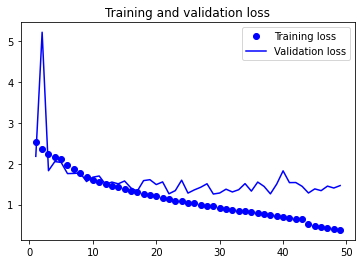

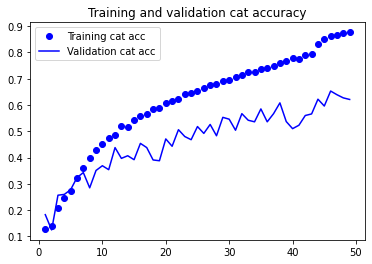

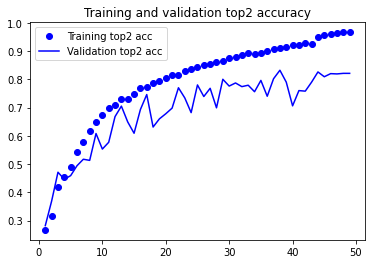

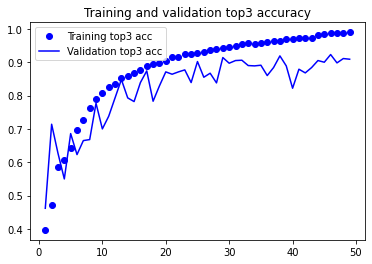

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1000/1000 [==============================] - 14s 13ms/step
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'scc': 6, 'vasc': 7}
Confusion matrix, without normalization
[[ 12  10   8   1   4   1   5   0]
 [  4 131  22   1   7  12   6   0]
 [  5  18 224   3  65  16   8   7]
 [  0   2   0  18   1   1   0   0]
 [  1   8  51   0 144  12   5   2]
 [  0   6   8   0   8  72   0   0]
 [  2   9  13   0  10   0  21   0]
 [  0   3   1   1   0   0   0  31]]
              precision    recall  f1-score   support

       akiec       0.50      0.29      0.37        41
         bcc       0.70      0.72      0.71       183
         bkl       0.69      0.65      0.67       346
          df       0.75      0.82      0.78        22
         mel       0.60      0.65      0.62       223
          nv       0.63      0.77      0.69        94
         scc       0.47      0.38      0.42        55
        vasc       0.78      0.86      0.82        36

    accuracy                           0.65      1

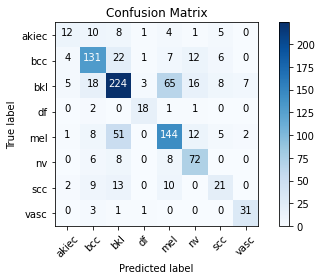

In [136]:
Xception_structure(image_height=299,image_width=299,es_patience=20,lr_patience=5,min_learningrate=0.0000001,epochs_num=300)

Found 39798 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
91897856/91884032 [==============================] - 2s 0us/step
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Epoch 1/300
507/507 [==============================] - 106s 168ms/step - loss: 2.4248 - categorical_accuracy: 0.1432 - top_2_accuracy: 0.3124 - top_3_accuracy: 0.4746 - val_loss: 1.9797 - val_categorical_accuracy: 0.1724 - val_top_2_accuracy: 0.3241 - val_top_3_accuracy: 0.4103

Epoch 00001: val_categorical_accuracy improved from -inf to 0.17241, saving model to model_X.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
507/507 [==============================] - 85s 167ms/step - loss: 2.2228 - categorical_accuracy: 0.1535 - top_2_accuracy: 0.3546 - top_3_accuracy: 0.5231 - val_loss: 3.2840 - val_categorical_accuracy: 0.2552 - val_top_2_accuracy: 0.4483 - val_top_3_accuracy: 0.6103

Epoch 00002: val_categorical_accuracy improved from 0.17241 to 0.25517, saving model to model_X.h5
Epoch 3/300
507/507 [==============================] - 85s 167ms/step - loss: 2.1182 - categorical_accuracy: 0.2400 - top_2_accuracy: 0.4653 - top_3_accuracy: 0.6385 - val_loss: 1.9764 - val_categorical_accuracy: 0.2552 - val_top_2_accuracy: 0.4690 - val_top_3_accuracy: 0.6276

Epoch 00003: val_categorical_accuracy did not improve from 0.25517
Epoch 4/300
507/507 [==============================] - 85s 167ms/step - loss: 2.0183 - categorical_accuracy: 0.2994 - top_2_accuracy: 0.5189 - top_3_accuracy: 0.6888 - val_loss: 2.7039 - val_categorical_accuracy: 0.2310 - val_top_2_accuracy: 0.4759 - val_top_3_accuracy: 0.658

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.9102334976196289
val_cat_acc: 0.6310344934463501
val_top_2_acc: 0.8793103694915771
val_top_3_acc: 0.9379310607910156
val_loss: 1.0129528045654297
val_cat_acc: 0.6896551847457886
val_top_2_acc: 0.8758620619773865
val_top_3_acc: 0.931034505367279


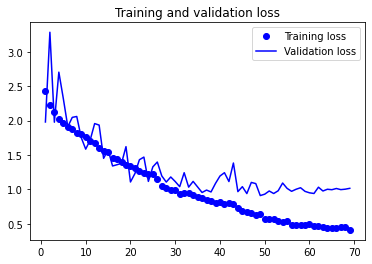

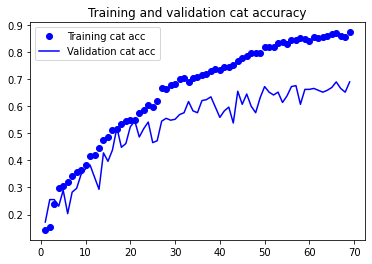

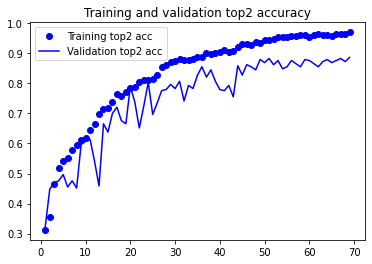

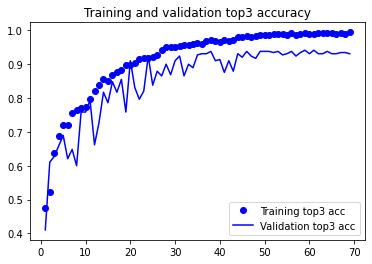

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


290/290 [==============================] - 3s 7ms/step
Confusion matrix, without normalization
[[30  5  5  0  8  2  0]
 [ 4 43  1  0  1  1  0]
 [ 2  2 32  0  9  5  0]
 [ 1  1  2 14  0  2  0]
 [ 3  0  2  0 38  7  0]
 [ 0  0 17  0  7 26  0]
 [ 0  0  1  0  0  2 17]]
              precision    recall  f1-score   support

       akiec       0.75      0.60      0.67        50
         bcc       0.84      0.86      0.85        50
         bkl       0.53      0.64      0.58        50
          df       1.00      0.70      0.82        20
         mel       0.60      0.76      0.67        50
          nv       0.58      0.52      0.55        50
        vasc       1.00      0.85      0.92        20

    accuracy                           0.69       290
   macro avg       0.76      0.70      0.72       290
weighted avg       0.71      0.69      0.69       290



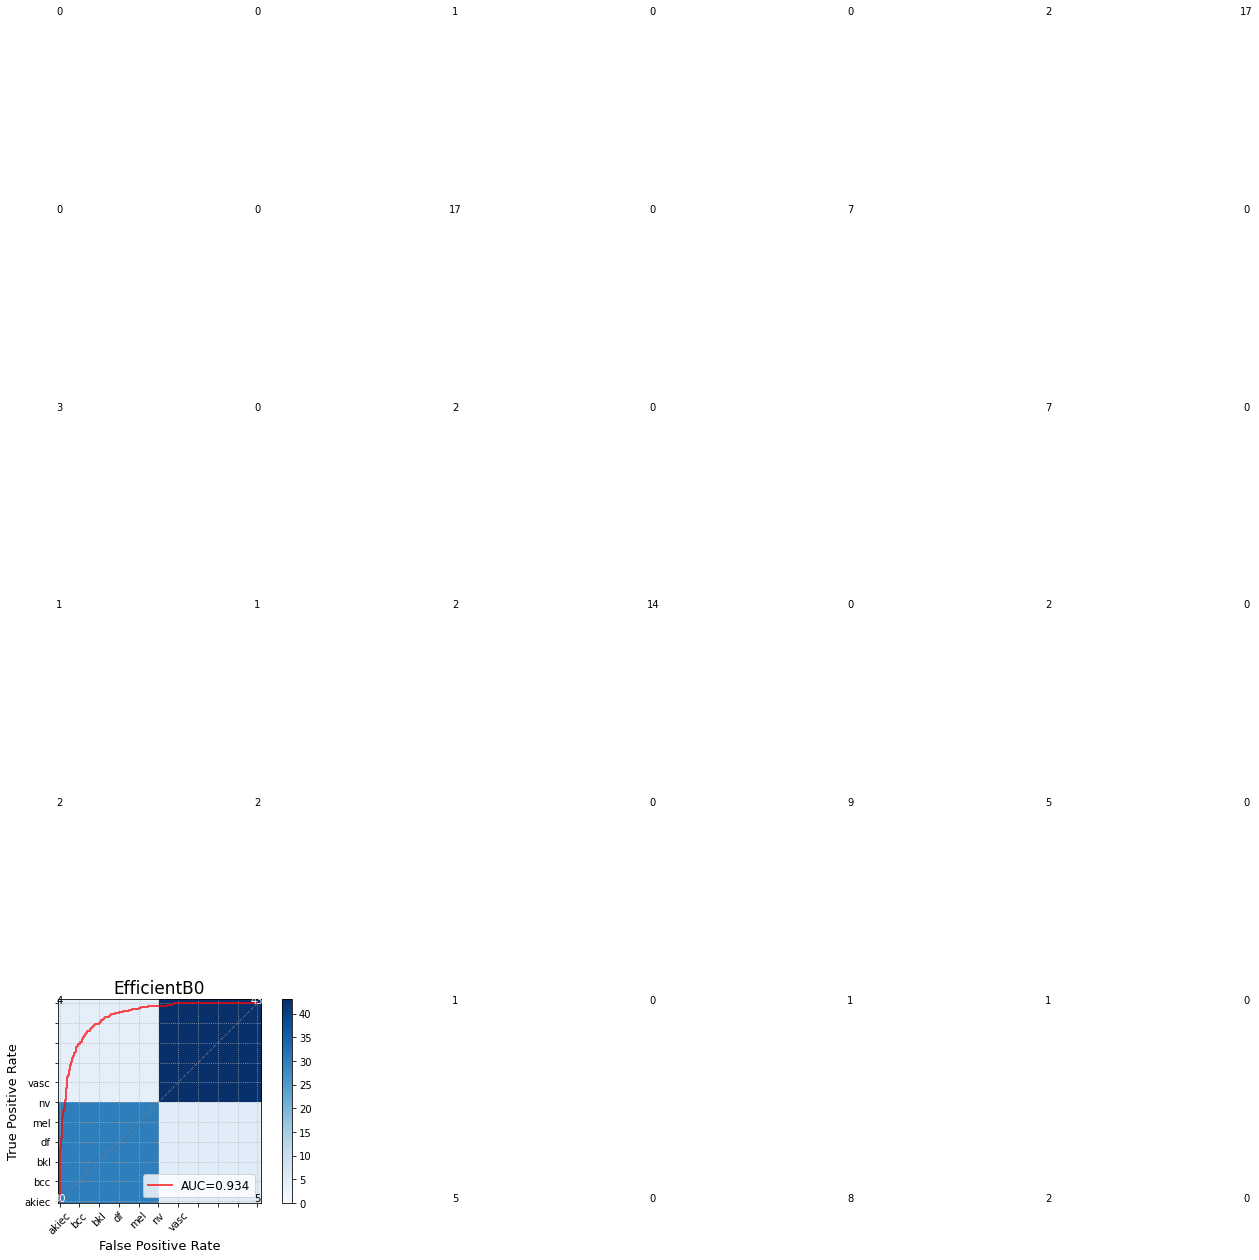

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


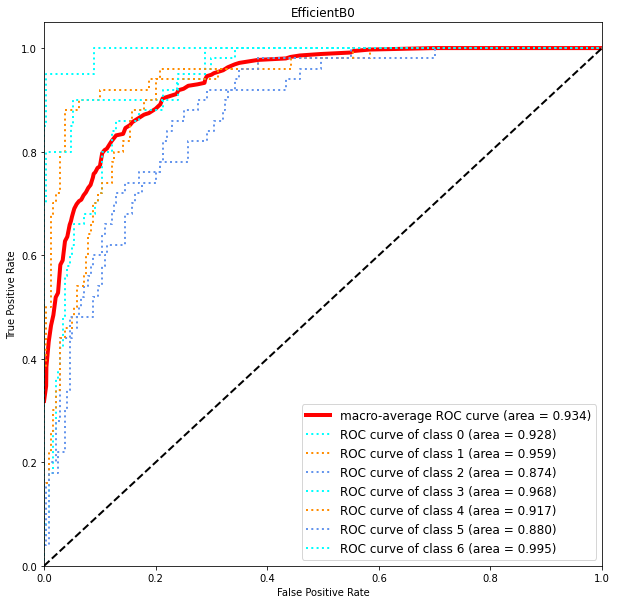

In [ ]:
Xception_structure(image_height=299,image_width=299,es_patience=20,lr_patience=5,min_learningrate=0.0000001,epochs_num=300)

In [ ]:
Xception_structure(image_height=299,image_width=299,es_patience=20,lr_patience=5,min_learningrate=0.0000001,epochs_num=300)

All sample

Found 40453 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
91897856/91884032 [==============================] - 2s 0us/step
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Epoch 1/300
973/973 [==============================] - 180s 164ms/step - loss: 2.2809 - categorical_accuracy: 0.1813 - top_2_accuracy: 0.3714 - top_3_accuracy: 0.5301 - val_loss: 1.8465 - val_categorical_accuracy: 0.2724 - val_top_2_accuracy: 0.4552 - val_top_3_accuracy: 0.5448

Epoch 00001: val_categorical_accuracy improved from -inf to 0.27241, saving model to model_X.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
973/973 [==============================] - 159s 163ms/step - loss: 1.9308 - categorical_accuracy: 0.3482 - top_2_accuracy: 0.5456 - top_3_accuracy: 0.7053 - val_loss: 1.8899 - val_categorical_accuracy: 0.3448 - val_top_2_accuracy: 0.5207 - val_top_3_accuracy: 0.7448

Epoch 00002: val_categorical_accuracy improved from 0.27241 to 0.34483, saving model to model_X.h5
Epoch 3/300
973/973 [==============================] - 159s 163ms/step - loss: 1.7393 - categorical_accuracy: 0.4109 - top_2_accuracy: 0.6171 - top_3_accuracy: 0.7683 - val_loss: 2.5792 - val_categorical_accuracy: 0.3552 - val_top_2_accuracy: 0.4724 - val_top_3_accuracy: 0.6552

Epoch 00003: val_categorical_accuracy improved from 0.34483 to 0.35517, saving model to model_X.h5
Epoch 4/300
973/973 [==============================] - 159s 163ms/step - loss: 1.6379 - categorical_accuracy: 0.4514 - top_2_accuracy: 0.6564 - top_3_accuracy: 0.7989 - val_loss: 1.7262 - val_categorical_accuracy: 0.4207 - val_top_2_accuracy:

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.858462393283844
val_cat_acc: 0.6724137663841248
val_top_2_acc: 0.8413792848587036
val_top_3_acc: 0.9379310607910156
val_loss: 0.9136274456977844
val_cat_acc: 0.7241379022598267
val_top_2_acc: 0.8413792848587036
val_top_3_acc: 0.9379310607910156


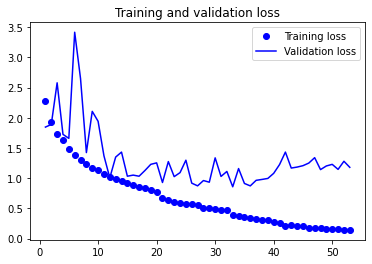

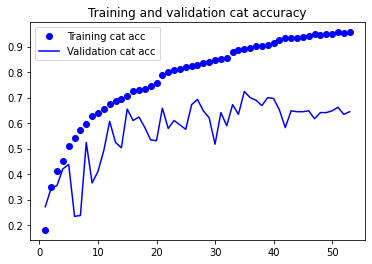

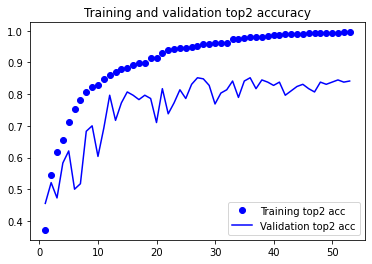

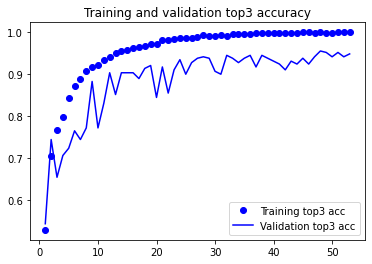

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


290/290 [==============================] - 3s 7ms/step
Confusion matrix, without normalization
[[23  9  8  0  6  4  0]
 [ 3 43  3  0  0  1  0]
 [ 2  0 27  0 13  8  0]
 [ 1  0  1 10  1  7  0]
 [ 3  3  3  0 39  2  0]
 [ 0  0  0  0  1 49  0]
 [ 0  1  0  0  0  0 19]]
              precision    recall  f1-score   support

       akiec       0.72      0.46      0.56        50
         bcc       0.77      0.86      0.81        50
         bkl       0.64      0.54      0.59        50
          df       1.00      0.50      0.67        20
         mel       0.65      0.78      0.71        50
          nv       0.69      0.98      0.81        50
        vasc       1.00      0.95      0.97        20

    accuracy                           0.72       290
   macro avg       0.78      0.72      0.73       290
weighted avg       0.74      0.72      0.71       290



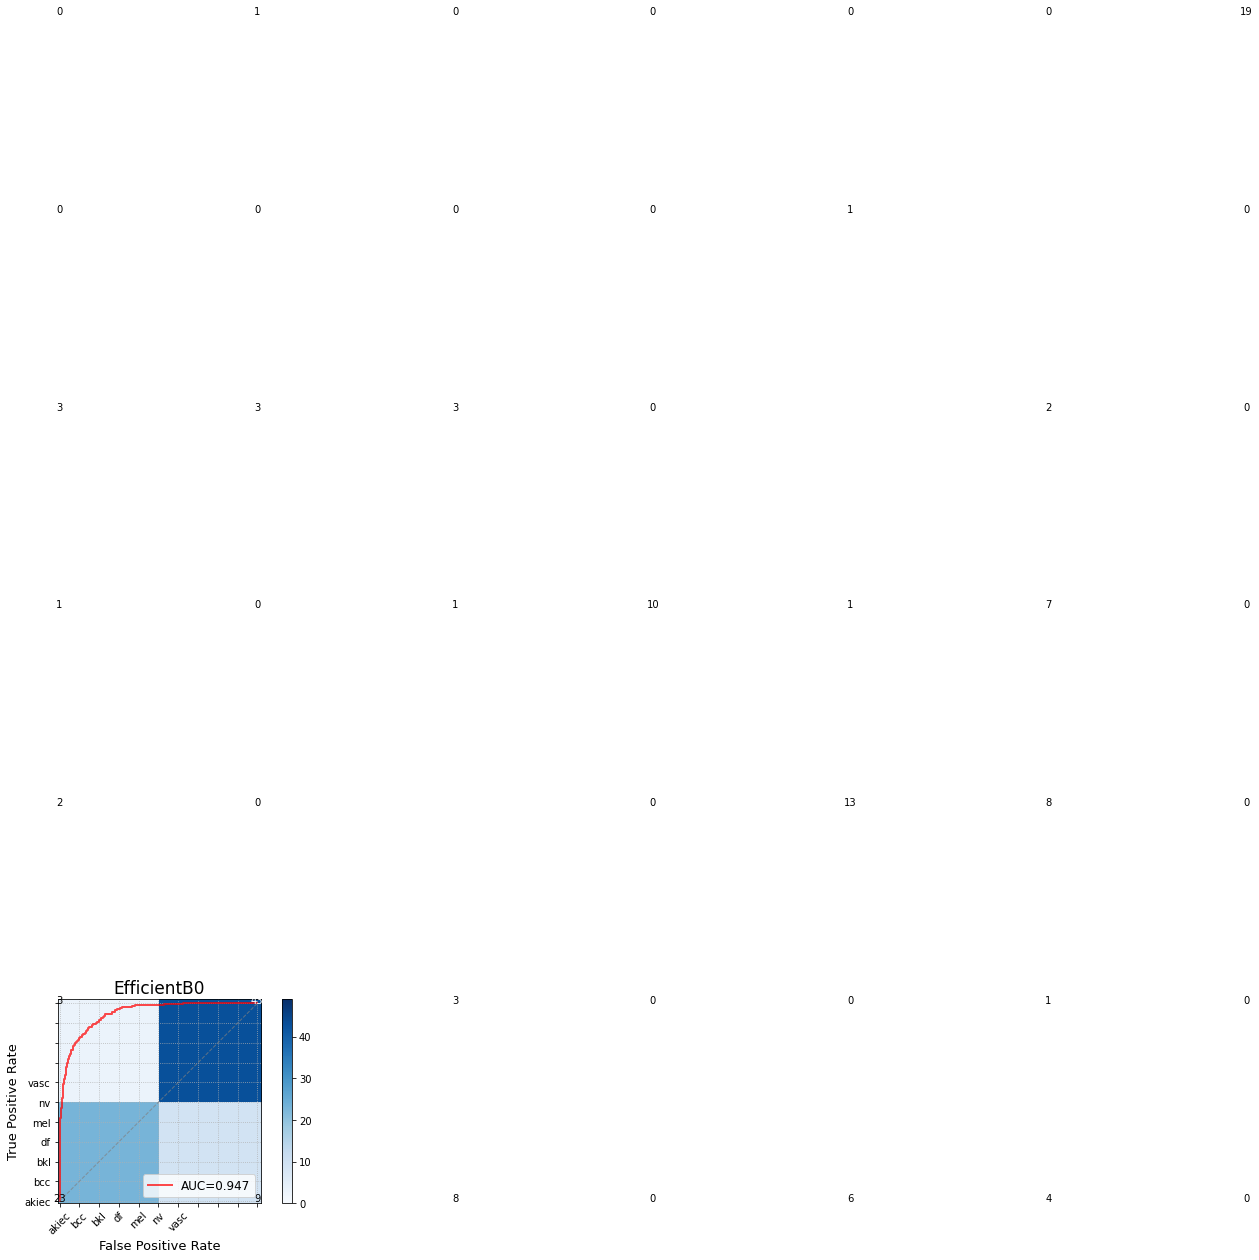

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


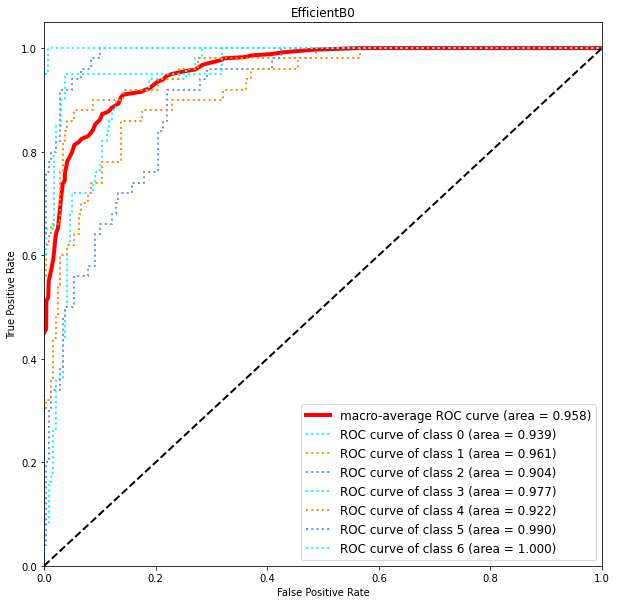

In [ ]:
Xception_structure(image_height=299,image_width=299,es_patience=20,lr_patience=5,min_learningrate=0.0000001,epochs_num=300)

Found 40453 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Epoch 1/300
973/973 [==============================] - 164s 165ms/step - loss: 2.2329 - categorical_accuracy: 0.1973 - top_2_accuracy: 0.3756 - top_3_accuracy: 0.5364 - val_loss: 2.3303 - val_categorical_accuracy: 0.3414 - val_top_2_accuracy: 0.4828 - val_top_3_accuracy: 0.6483

Epoch 00001: val_categorical_accuracy improved from -inf to 0.34138, saving model to model_X.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
973/973 [==============================] - 160s 164ms/step - loss: 1.8697 - categorical_accuracy: 0.3775 - top_2_accuracy: 0.5642 - top_3_accuracy: 0.7158 - val_loss: 2.1545 - val_categorical_accuracy: 0.2897 - val_top_2_accuracy: 0.4345 - val_top_3_accuracy: 0.6172

Epoch 00002: val_categorical_accuracy did not improve from 0.34138
Epoch 3/300
973/973 [==============================] - 160s 164ms/step - loss: 1.6428 - categorical_accuracy: 0.4493 - top_2_accuracy: 0.6481 - top_3_accuracy: 0.7976 - val_loss: 2.3413 - val_categorical_accuracy: 0.3034 - val_top_2_accuracy: 0.4621 - val_top_3_accuracy: 0.6172

Epoch 00003: val_categorical_accuracy did not improve from 0.34138
Epoch 4/300
973/973 [==============================] - 160s 164ms/step - loss: 1.5135 - categorical_accuracy: 0.4865 - top_2_accuracy: 0.6966 - top_3_accuracy: 0.8333 - val_loss: 1.8871 - val_categorical_accuracy: 0.3345 - val_top_2_accuracy: 0.5345 - val_top_3_accuracy: 0.6966

Epoch 00004: val_categoric

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.7659958600997925
val_cat_acc: 0.7586206793785095
val_top_2_acc: 0.8758620619773865
val_top_3_acc: 0.9551724195480347
val_loss: 0.7659958600997925
val_cat_acc: 0.7586206793785095
val_top_2_acc: 0.8758620619773865
val_top_3_acc: 0.9551724195480347


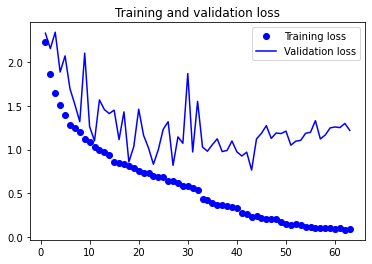

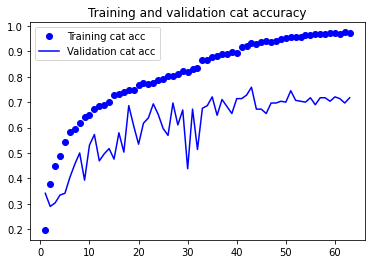

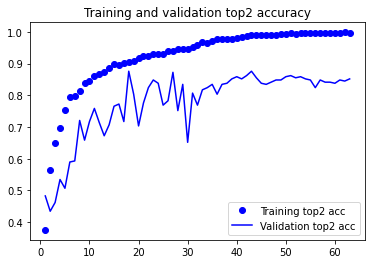

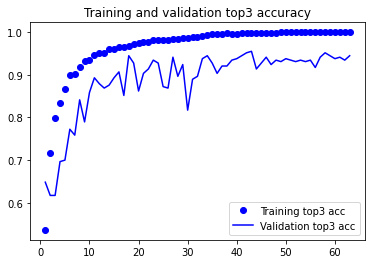

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


290/290 [==============================] - 3s 7ms/step
Confusion matrix, without normalization
[[32  7  5  0  3  3  0]
 [ 2 41  2  0  0  5  0]
 [ 0  1 38  0  1 10  0]
 [ 1  0  0 13  1  5  0]
 [ 2  1  8  0 28 11  0]
 [ 0  0  0  0  1 49  0]
 [ 0  1  0  0  0  0 19]]
              precision    recall  f1-score   support

       akiec       0.86      0.64      0.74        50
         bcc       0.80      0.82      0.81        50
         bkl       0.72      0.76      0.74        50
          df       1.00      0.65      0.79        20
         mel       0.82      0.56      0.67        50
          nv       0.59      0.98      0.74        50
        vasc       1.00      0.95      0.97        20

    accuracy                           0.76       290
   macro avg       0.83      0.77      0.78       290
weighted avg       0.79      0.76      0.76       290



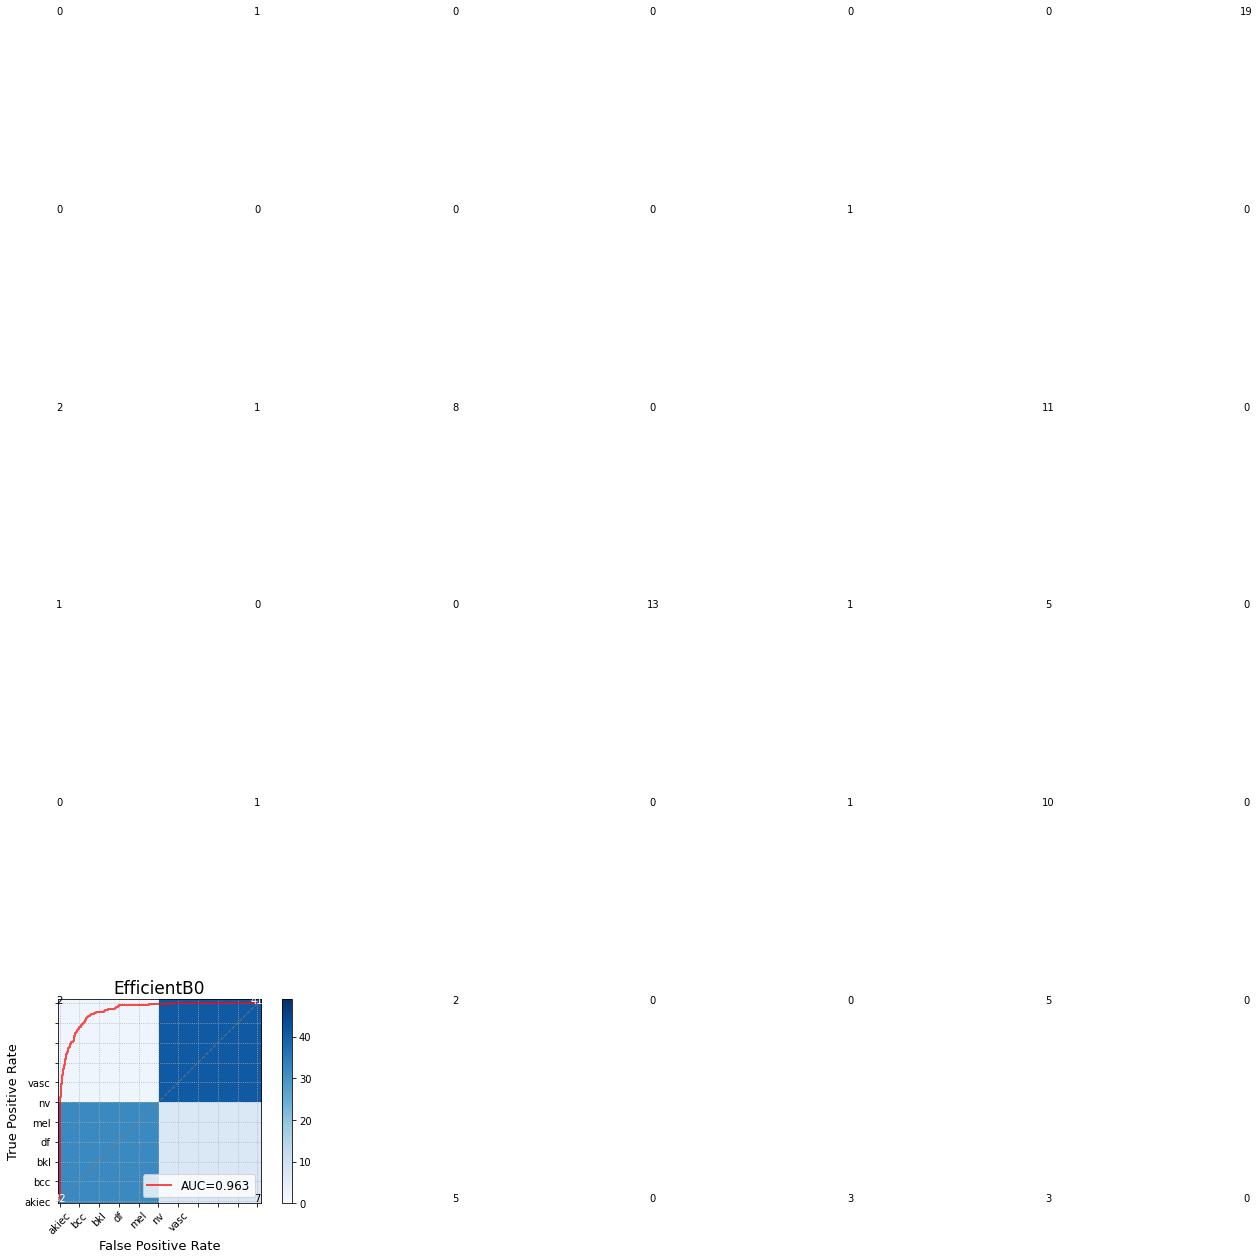

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


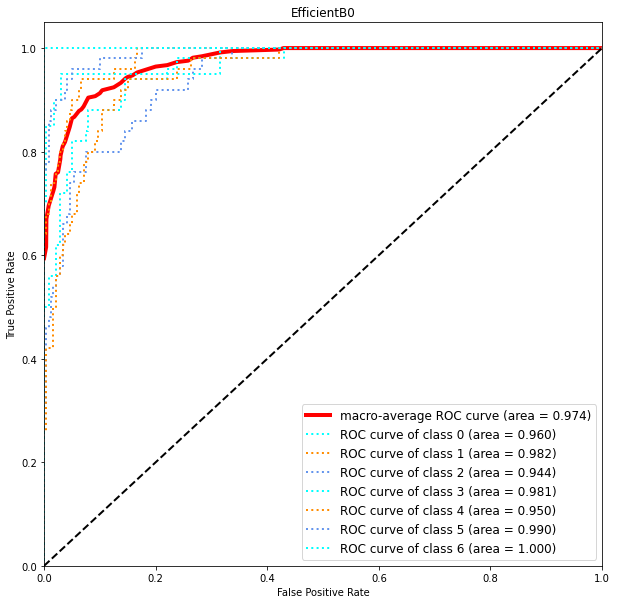

In [ ]:
Xception_structure(image_height=299,image_width=299,es_patience=20,lr_patience=5,min_learningrate=0.0000001,epochs_num=300)

In [ ]:
Xception_structure(image_height=299,image_width=299,es_patience=20,lr_patience=5,min_learningrate=0.0000001,epochs_num=300)

Found 40453 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Epoch 1/300
973/973 [==============================] - 164s 164ms/step - loss: 2.4391 - categorical_accuracy: 0.1579 - top_2_accuracy: 0.3227 - top_3_accuracy: 0.4815 - val_loss: 2.3770 - val_categorical_accuracy: 0.1724 - val_top_2_accuracy: 0.3724 - val_top_3_accuracy: 0.5552

Epoch 00001: val_categorical_accuracy improved from -inf to 0.17241, saving model to model_X.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
973/973 [==============================] - 159s 164ms/step - loss: 2.0730 - categorical_accuracy: 0.2681 - top_2_accuracy: 0.4672 - top_3_accuracy: 0.6217 - val_loss: 2.1042 - val_categorical_accuracy: 0.2621 - val_top_2_accuracy: 0.3759 - val_top_3_accuracy: 0.5207

Epoch 00002: val_categorical_accuracy improved from 0.17241 to 0.26207, saving model to model_X.h5
Epoch 3/300
973/973 [==============================] - 159s 164ms/step - loss: 1.8158 - categorical_accuracy: 0.3865 - top_2_accuracy: 0.5871 - top_3_accuracy: 0.7399 - val_loss: 2.1312 - val_categorical_accuracy: 0.3034 - val_top_2_accuracy: 0.4517 - val_top_3_accuracy: 0.6310

Epoch 00003: val_categorical_accuracy improved from 0.26207 to 0.30345, saving model to model_X.h5
Epoch 4/300
973/973 [==============================] - 159s 163ms/step - loss: 1.7020 - categorical_accuracy: 0.4270 - top_2_accuracy: 0.6255 - top_3_accuracy: 0.7784 - val_loss: 2.9552 - val_categorical_accuracy: 0.2966 - val_top_2_accuracy:

# **b0**

In [ ]:
def EfficientB0_structure(image_height,image_width,es_patience,lr_patience,min_learningrate,epochs_num):
  train_path = '/content/base_dir/train_dir'
  valid_path = '/content/base_dir/val_dir'

  num_train_samples = len(df_train)
  num_val_samples = len(df_val)
  train_batch_size = 10
  val_batch_size = 10
  # image_height = 225
  # image_width = 300

  train_steps = np.ceil(num_train_samples / train_batch_size)
  val_steps = np.ceil(num_val_samples / val_batch_size)

  ####################################################################
  datagen = ImageDataGenerator(
      preprocessing_function= \
      tf.keras.applications.efficientnet.preprocess_input)

  train_batches = datagen.flow_from_directory(train_path,
                                              target_size=(image_height,image_width),
                                              batch_size=train_batch_size)

  valid_batches = datagen.flow_from_directory(valid_path,
                                              target_size=(image_height,image_width),
                                              batch_size=val_batch_size)

  # Note: shuffle=False causes the test dataset to not be shuffled
  test_batches = datagen.flow_from_directory(valid_path,
                                              target_size=(image_height,image_width),
                                              batch_size=1,
                                              shuffle=False)
  #####################################################################
  # create a copy of a mobilenet model
  model_EB0 = tf.keras.applications.efficientnet.EfficientNetB0()
  # model_EB0.summary()
  # CREATE THE MODEL ARCHITECTURE

  # This will include all layers up to and including global_average_pooling2d_1
  x = model_EB0.layers[-3].output

  # Create a new dense layer for predictions
  # 7 corresponds to the number of classes
  x = Dropout(0.25)(x)
  predictions = Dense(7, activation='softmax')(x)

  # inputs=mobile.input selects the input layer, outputs=predictions refers to the dense layer we created above.

  model_EB0 = Model(inputs=model_EB0.input, outputs=predictions)

  # model_EB0.summary()
  #######################################################################
  # Get the labels that are associated with each index
  print(valid_batches.class_indices)


  # Add weights to try to make the model more sensitive to melanoma

  class_weights={
      0: 1.0, # akiec
      1: 1.0, # bcc
      2: 1.0, # bkl
      3: 1.0, # df
      4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
      5: 1.0, # nv
      6: 1.0, # vasc
  }
  #######################################################################
  model_EB0.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', 
                metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

  filepath = "model_EB0.h5" #inceptionV3
  checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                              save_best_only=True, mode='max')

  es_callback = tf.keras.callbacks.EarlyStopping(patience=es_patience, 
                                                verbose=1, 
                                                restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=lr_patience, 
                                    verbose=1, mode='max', min_lr=min_learningrate)
                                
                                
  callbacks_list = [es_callback,checkpoint, reduce_lr]

  history = model_EB0.fit(train_batches, steps_per_epoch=train_steps, 
                                class_weight=class_weights,
                      validation_data=valid_batches,
                      validation_steps=val_steps,
                      epochs=epochs_num, verbose=1,
                    callbacks=callbacks_list)
  ######################################################################### Evaluation
  #Draw loss figure
  # get the metric names so we can use evaulate_generator
  model_EB0.metrics_names

  # Here the the last epoch will be used.

  val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
  model_EB0.evaluate_generator(test_batches, 
                          steps=len(df_val))

  print('val_loss:', val_loss)
  print('val_cat_acc:', val_cat_acc)
  print('val_top_2_acc:', val_top_2_acc)
  print('val_top_3_acc:', val_top_3_acc)

  # Here the best epoch will be used.

  model_EB0.load_weights('model_EB0.h5')

  val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
  model_EB0.evaluate_generator(test_batches, 
                          steps=len(df_val))

  print('val_loss:', val_loss)
  print('val_cat_acc:', val_cat_acc)
  print('val_top_2_acc:', val_top_2_acc)
  print('val_top_3_acc:', val_top_3_acc)


  # display the loss and accuracy curves

  import matplotlib.pyplot as plt

  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_top2_acc = history.history['top_2_accuracy']
  val_top2_acc = history.history['val_top_2_accuracy']
  train_top3_acc = history.history['top_3_accuracy']
  val_top3_acc = history.history['val_top_3_accuracy']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.figure()

  plt.plot(epochs, acc, 'bo', label='Training cat acc')
  plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
  plt.title('Training and validation cat accuracy')
  plt.legend()
  plt.figure()


  plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
  plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
  plt.title('Training and validation top2 accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
  plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
  plt.title('Training and validation top3 accuracy')
  plt.legend()


  plt.show()
  ######################################################################### Evaluation
  #Draw Confusion matrix

  # Get the labels of the test images.

  test_labels = test_batches.classes
  # We need these to plot the confusion matrix.
  test_labels

  # Print the label associated with each class
  test_batches.class_indices

  # make a prediction
  predictions = model_EB0.predict_generator(test_batches, steps=len(df_val), verbose=1)

  test_labels.shape
  # argmax returns the index of the max value in a row
  cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
  test_batches.class_indices

  # Define the labels of the class indices. These need to match the 
  # order shown above.
  cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

  plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
  ######################################################################### Evaluation
  # Get report
  # Get the index of the class with the highest probability score
  y_pred = np.argmax(predictions, axis=1)

  # Get the labels of the test images.
  y_true = test_batches.classes

  from sklearn.metrics import classification_report

  # Generate a classification report
  report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

  print(report)
  ######################################################################### Evaluation
  #Draw AUC
  from sklearn import metrics
  from itertools import chain
  def f(i):
    l = [0, 0, 0, 0, 0, 0, 0]
    l[i] = 1
    return l
  #计算
  y_pre = list(map(f,test_batches.classes))
  y = sum(y_pre,[])
  scores = list(chain.from_iterable(predictions))

  fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)

  from sklearn.metrics import auc 
  metrics.auc(fpr, tpr) 
  auc = metrics.auc(fpr, tpr)
  #image drawing
  plt.plot(fpr, tpr, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % auc)
  plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
  plt.xlim((-0.01, 1.02))
  plt.ylim((-0.01, 1.02))
  plt.xticks(np.arange(0, 1.1, 0.1))
  plt.yticks(np.arange(0, 1.1, 0.1))
  plt.xlabel('False Positive Rate', fontsize=13)
  plt.ylabel('True Positive Rate', fontsize=13)
  plt.grid(b=True, ls=':')
  plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
  plt.title(u'EfficientB0', fontsize=17)
  plt.show()

  # 引入必要的库
  import matplotlib.pyplot as plt
  from itertools import cycle
  from sklearn import svm, datasets
  from sklearn.metrics import roc_curve, auc
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import label_binarize
  from sklearn.multiclass import OneVsRestClassifier
  from scipy import interp

  yscore = predictions.tolist()


  # 计算每一类的ROC
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(cm_plot_labels)):
      fpr[i], tpr[i], thresholds = metrics.roc_curve([m[i] for m in y_pre], [n[i] for n in yscore], pos_label=1)
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute macro-average ROC curve and ROC area（方法一）
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(cm_plot_labels))]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(len(cm_plot_labels)):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])
  # Finally average it and compute AUC
  mean_tpr /= len(cm_plot_labels)
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


  # Plot all ROC curves
  lw=2
  plt.figure(figsize=(10,10))


  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
          color='r',  linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(len(cm_plot_labels)), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,linestyle=':',
              label='ROC curve of class {0} (area = {1:0.3f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('EfficientB0')
  plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
  plt.show()

## **png**

Found 40453 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Epoch 1/200
973/973 [==============================] - 76s 71ms/step - loss: 2.0698 - categorical_accuracy: 0.3344 - top_2_accuracy: 0.5351 - top_3_accuracy: 0.6925 - val_loss: 2.6074 - val_categorical_accuracy: 0.2241 - val_top_2_accuracy: 0.4483 - val_top_3_accuracy: 0.6483

Epoch 00001: val_categorical_accuracy improved from -inf to 0.22414, saving model to model_EB0.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
973/973 [==============================] - 68s 70ms/step - loss: 1.7082 - categorical_accuracy: 0.4406 - top_2_accuracy: 0.6518 - top_3_accuracy: 0.7947 - val_loss: 1.8774 - val_categorical_accuracy: 0.3379 - val_top_2_accuracy: 0.4931 - val_top_3_accuracy: 0.6793

Epoch 00002: val_categorical_accuracy improved from 0.22414 to 0.33793, saving model to model_EB0.h5
Epoch 3/200
973/973 [==============================] - 68s 70ms/step - loss: 1.5948 - categorical_accuracy: 0.4776 - top_2_accuracy: 0.6983 - top_3_accuracy: 0.8303 - val_loss: 1.8078 - val_categorical_accuracy: 0.4345 - val_top_2_accuracy: 0.6379 - val_top_3_accuracy: 0.7931

Epoch 00003: val_categorical_accuracy improved from 0.33793 to 0.43448, saving model to model_EB0.h5
Epoch 4/200
973/973 [==============================] - 68s 70ms/step - loss: 1.5250 - categorical_accuracy: 0.4970 - top_2_accuracy: 0.7249 - top_3_accuracy: 0.8591 - val_loss: 3.0690 - val_categorical_accuracy: 0.2138 - val_top_2_accuracy: 0

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 1.0010015964508057
val_cat_acc: 0.6310344934463501
val_top_2_acc: 0.8275862336158752
val_top_3_acc: 0.9241379499435425
val_loss: 1.071494698524475
val_cat_acc: 0.6689655184745789
val_top_2_acc: 0.8275862336158752
val_top_3_acc: 0.9172413945198059


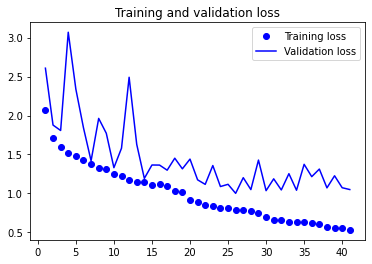

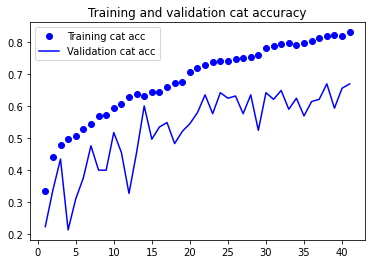

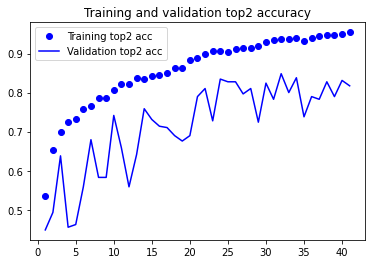

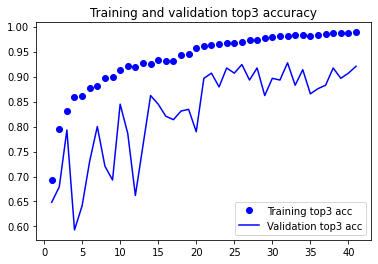

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


290/290 [==============================] - 5s 15ms/step
Confusion matrix, without normalization
[[19  7 10  0 12  2  0]
 [ 8 32  2  1  5  1  1]
 [ 0  1 31  1  5 12  0]
 [ 0  2  1  7  2  8  0]
 [ 0  1  3  0 39  7  0]
 [ 0  0  0  0  1 49  0]
 [ 0  1  0  0  0  2 17]]
              precision    recall  f1-score   support

       akiec       0.70      0.38      0.49        50
         bcc       0.73      0.64      0.68        50
         bkl       0.66      0.62      0.64        50
          df       0.78      0.35      0.48        20
         mel       0.61      0.78      0.68        50
          nv       0.60      0.98      0.75        50
        vasc       0.94      0.85      0.89        20

    accuracy                           0.67       290
   macro avg       0.72      0.66      0.66       290
weighted avg       0.69      0.67      0.65       290



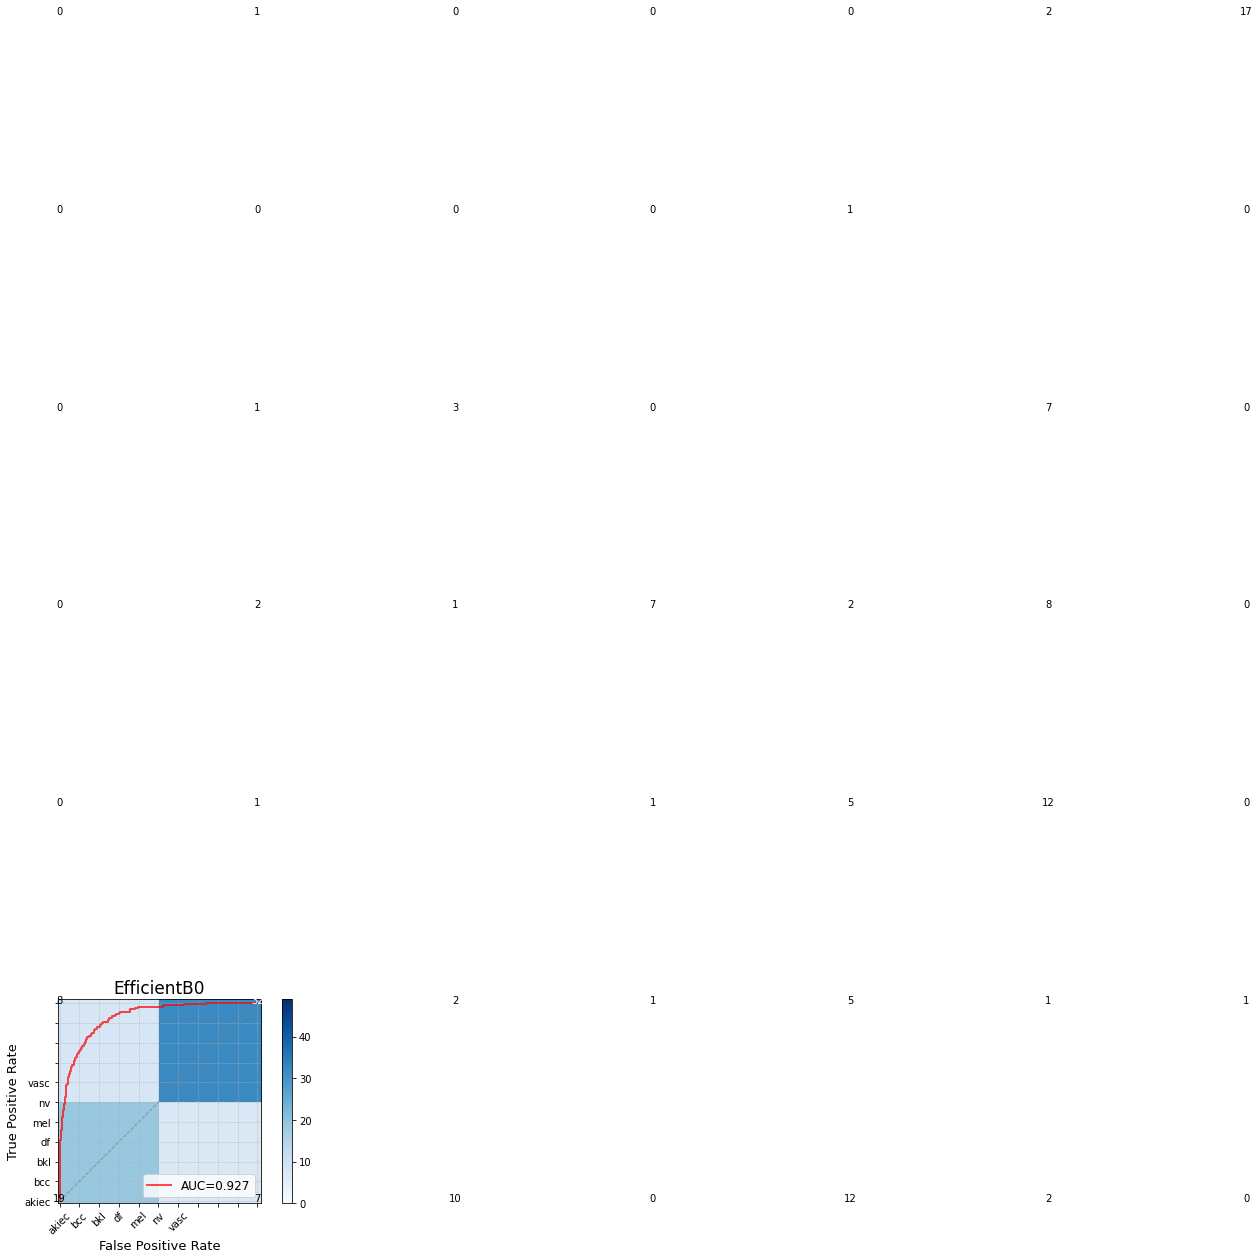

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


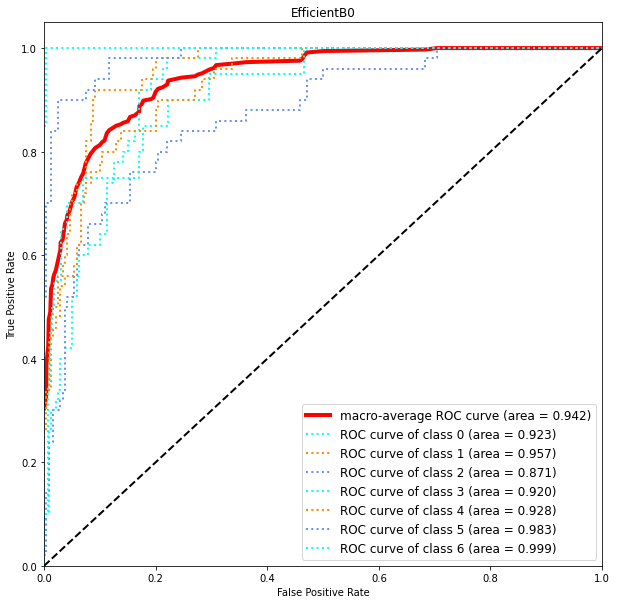

In [ ]:
EfficientB0_structure(image_height=224,image_width=224,es_patience=15,lr_patience=5,min_learningrate=0.0000001,epochs_num=200)

Found 40453 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Epoch 1/200
973/973 [==============================] - 76s 71ms/step - loss: 2.2261 - categorical_accuracy: 0.2742 - top_2_accuracy: 0.4624 - top_3_accuracy: 0.6166 - val_loss: 2.4635 - val_categorical_accuracy: 0.2448 - val_top_2_accuracy: 0.3483 - val_top_3_accuracy: 0.4724

Epoch 00001: val_categorical_accuracy improved from -inf to 0.24483, saving model to model_EB0.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
973/973 [==============================] - 68s 70ms/step - loss: 1.7287 - categorical_accuracy: 0.4229 - top_2_accuracy: 0.6392 - top_3_accuracy: 0.7863 - val_loss: 2.1642 - val_categorical_accuracy: 0.3621 - val_top_2_accuracy: 0.6276 - val_top_3_accuracy: 0.7517

Epoch 00002: val_categorical_accuracy improved from 0.24483 to 0.36207, saving model to model_EB0.h5
Epoch 3/200
973/973 [==============================] - 68s 70ms/step - loss: 1.6580 - categorical_accuracy: 0.4496 - top_2_accuracy: 0.6707 - top_3_accuracy: 0.8165 - val_loss: 1.6646 - val_categorical_accuracy: 0.3690 - val_top_2_accuracy: 0.6000 - val_top_3_accuracy: 0.7759

Epoch 00003: val_categorical_accuracy improved from 0.36207 to 0.36897, saving model to model_EB0.h5
Epoch 4/200
973/973 [==============================] - 68s 70ms/step - loss: 1.5808 - categorical_accuracy: 0.4749 - top_2_accuracy: 0.7004 - top_3_accuracy: 0.8388 - val_loss: 1.9115 - val_categorical_accuracy: 0.3828 - val_top_2_accuracy: 0

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 1.006207823753357
val_cat_acc: 0.6793103218078613
val_top_2_acc: 0.8275862336158752
val_top_3_acc: 0.9034482836723328
val_loss: 1.006207823753357
val_cat_acc: 0.6793103218078613
val_top_2_acc: 0.8275862336158752
val_top_3_acc: 0.9034482836723328


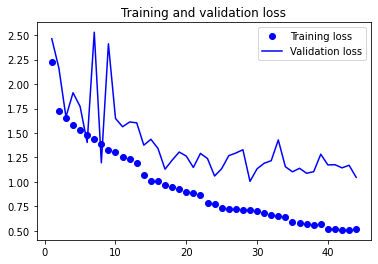

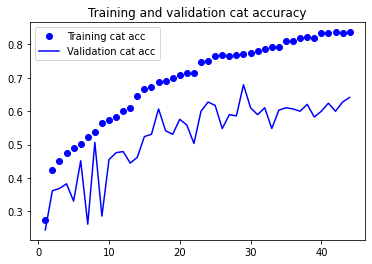

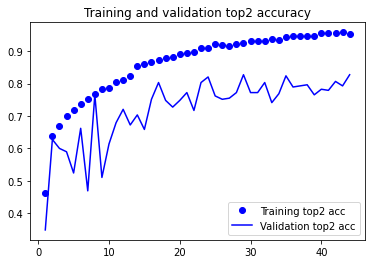

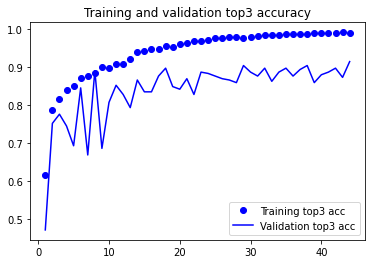

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


290/290 [==============================] - 5s 15ms/step
Confusion matrix, without normalization
[[29  9  5  0  7  0  0]
 [11 33  0  0  3  3  0]
 [ 4  2 26  0 10  8  0]
 [ 1  5  0  7  1  6  0]
 [ 0  2  5  0 37  6  0]
 [ 0  0  0  0  2 48  0]
 [ 0  0  0  0  0  3 17]]
              precision    recall  f1-score   support

       akiec       0.64      0.58      0.61        50
         bcc       0.65      0.66      0.65        50
         bkl       0.72      0.52      0.60        50
          df       1.00      0.35      0.52        20
         mel       0.62      0.74      0.67        50
          nv       0.65      0.96      0.77        50
        vasc       1.00      0.85      0.92        20

    accuracy                           0.68       290
   macro avg       0.75      0.67      0.68       290
weighted avg       0.70      0.68      0.67       290



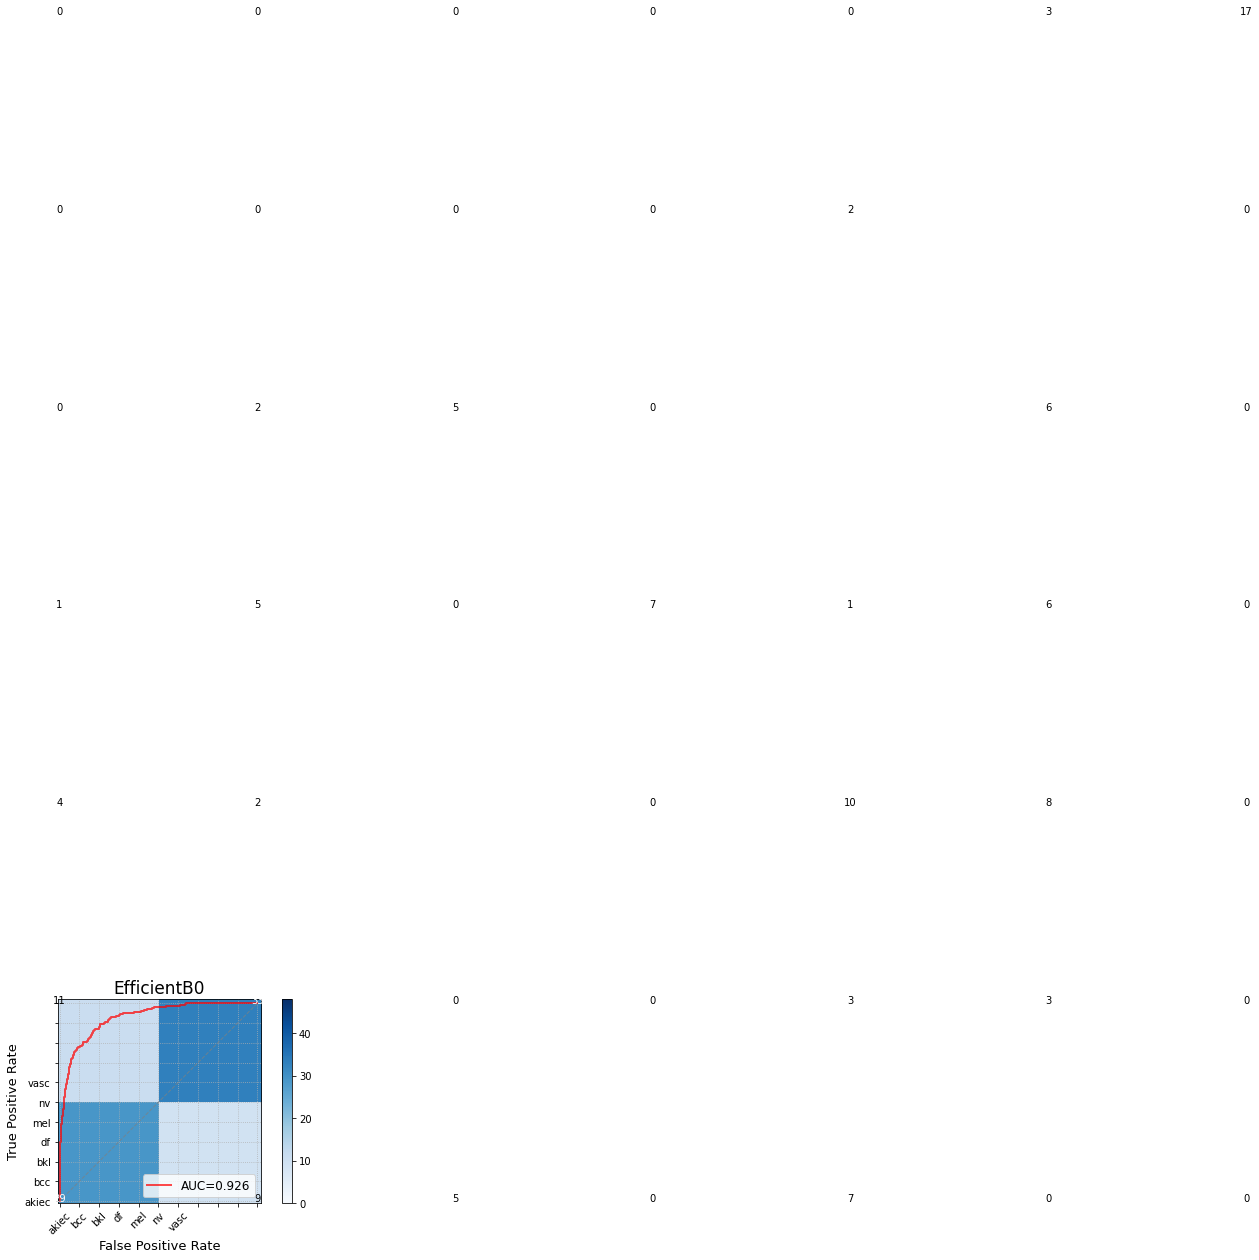

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


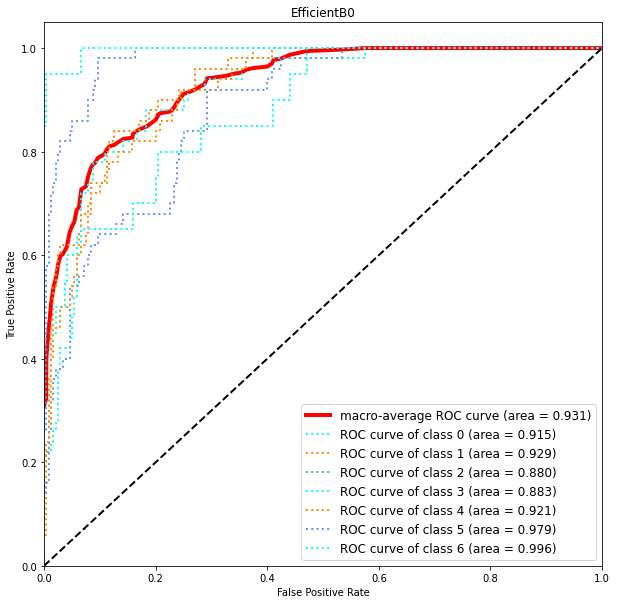

In [ ]:
EfficientB0_structure(image_height=224,image_width=224,es_patience=15,lr_patience=5,min_learningrate=0.0000001,epochs_num=200)

Found 40453 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
21848064/21834768 [==============================] - 1s 0us/step
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Epoch 1/200
973/973 [==============================] - 94s 71ms/step - loss: 2.1472 - categorical_accuracy: 0.2963 - top_2_accuracy: 0.4997 - top_3_accuracy: 0.6562 - val_loss: 3.7165 - val_categorical_accuracy: 0.2897 - val_top_2_accuracy: 0.4517 - val_top_3_accuracy: 0.6345

Epoch 00001: val_categorical_accuracy improved from -inf to 0.28966, saving model to model_EB0.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
973/973 [==============================] - 69s 71ms/step - loss: 1.7335 - categorical_accuracy: 0.4232 - top_2_accuracy: 0.6315 - top_3_accuracy: 0.7817 - val_loss: 2.0521 - val_categorical_accuracy: 0.3793 - val_top_2_accuracy: 0.6069 - val_top_3_accuracy: 0.7862

Epoch 00002: val_categorical_accuracy improved from 0.28966 to 0.37931, saving model to model_EB0.h5
Epoch 3/200
973/973 [==============================] - 69s 71ms/step - loss: 1.6132 - categorical_accuracy: 0.4597 - top_2_accuracy: 0.6714 - top_3_accuracy: 0.8124 - val_loss: 1.7469 - val_categorical_accuracy: 0.3862 - val_top_2_accuracy: 0.6069 - val_top_3_accuracy: 0.7724

Epoch 00003: val_categorical_accuracy improved from 0.37931 to 0.38621, saving model to model_EB0.h5
Epoch 4/200
973/973 [==============================] - 68s 70ms/step - loss: 1.5497 - categorical_accuracy: 0.4876 - top_2_accuracy: 0.7051 - top_3_accuracy: 0.8433 - val_loss: 1.5026 - val_categorical_accuracy: 0.4655 - val_top_2_accuracy: 0

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.8171747922897339
val_cat_acc: 0.682758629322052
val_top_2_acc: 0.8724138140678406
val_top_3_acc: 0.9413793087005615
val_loss: 0.8171747922897339
val_cat_acc: 0.682758629322052
val_top_2_acc: 0.8724138140678406
val_top_3_acc: 0.9413793087005615


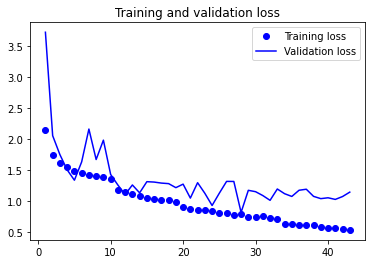

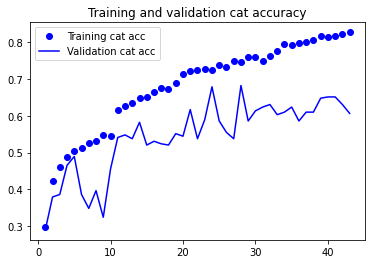

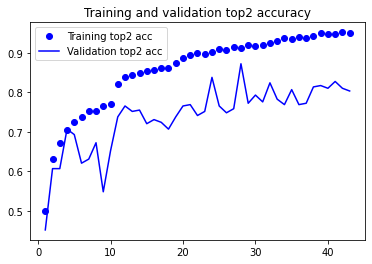

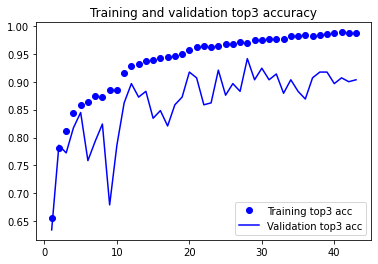

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


290/290 [==============================] - 5s 15ms/step
Confusion matrix, without normalization
[[23  6  8  0 10  3  0]
 [ 5 43  1  0  1  0  0]
 [ 5  1 24  1 10  9  0]
 [ 0  2  1 10  1  6  0]
 [ 0  3  9  1 31  6  0]
 [ 0  0  0  0  1 49  0]
 [ 0  1  1  0  0  0 18]]
              precision    recall  f1-score   support

       akiec       0.70      0.46      0.55        50
         bcc       0.77      0.86      0.81        50
         bkl       0.55      0.48      0.51        50
          df       0.83      0.50      0.62        20
         mel       0.57      0.62      0.60        50
          nv       0.67      0.98      0.80        50
        vasc       1.00      0.90      0.95        20

    accuracy                           0.68       290
   macro avg       0.73      0.69      0.69       290
weighted avg       0.69      0.68      0.67       290



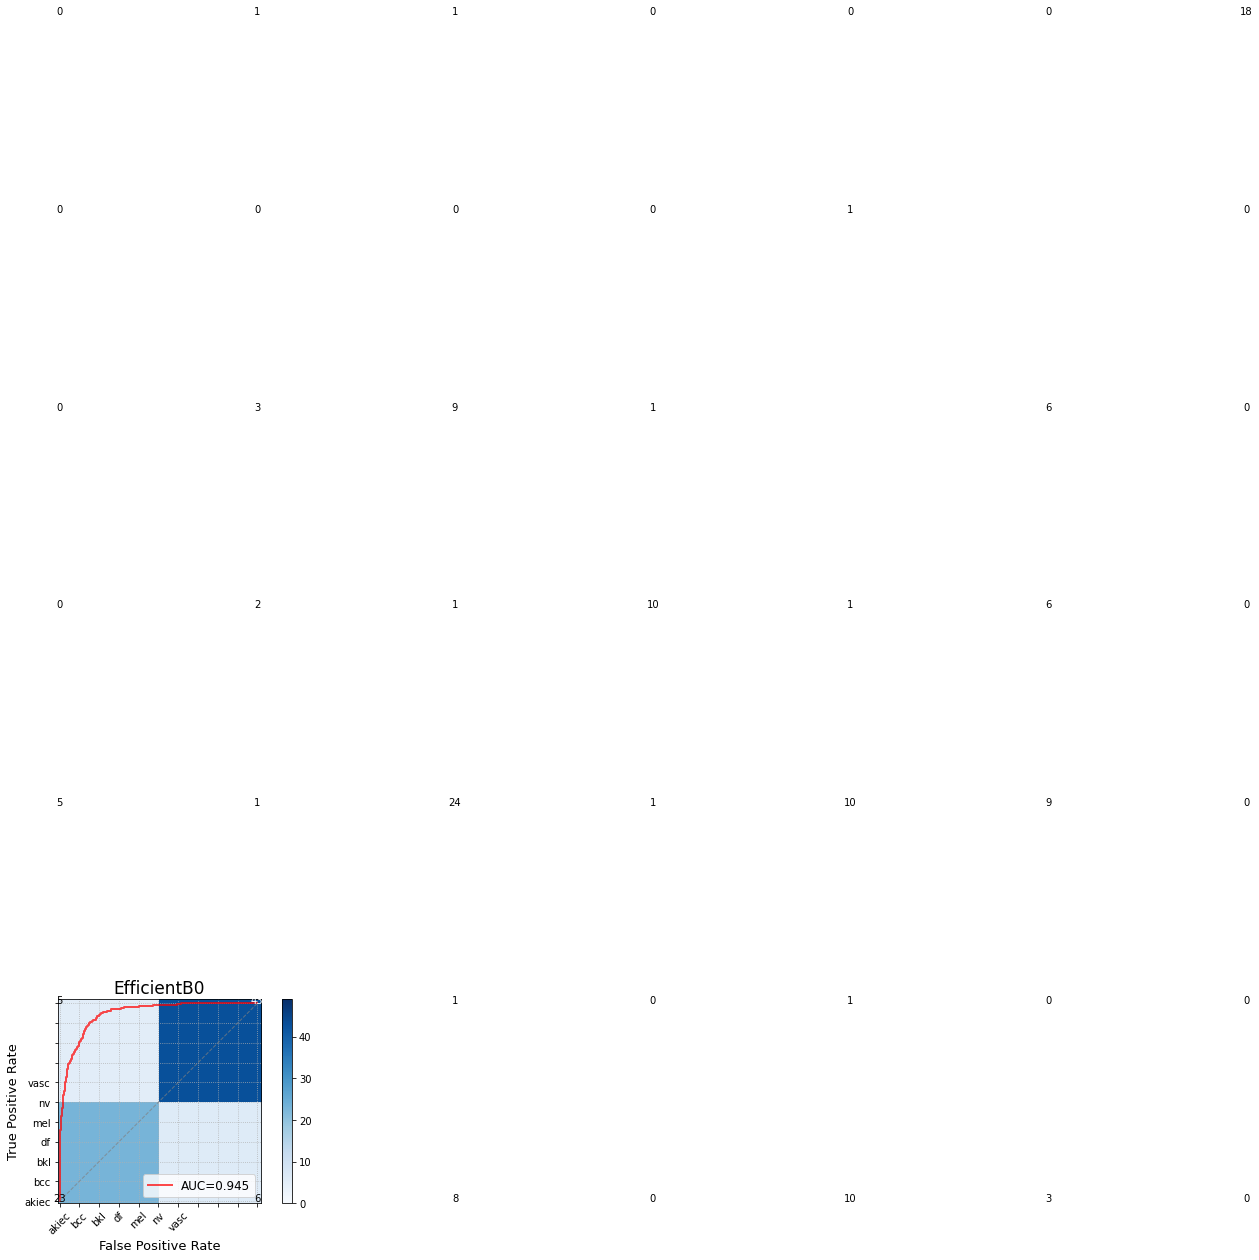

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


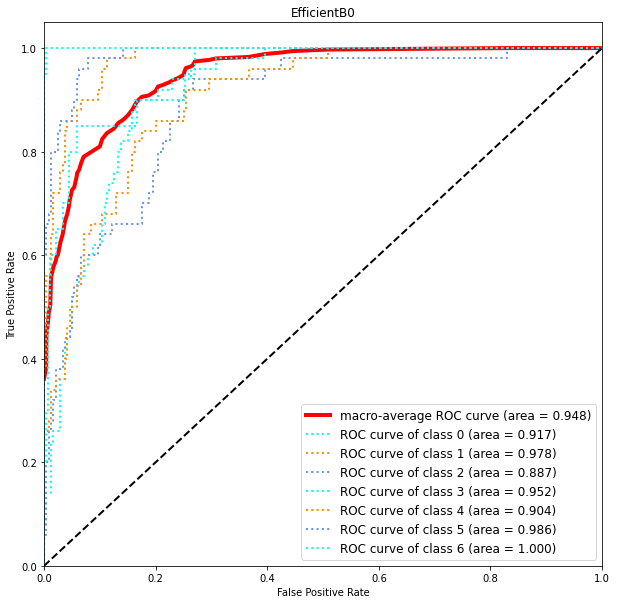

In [ ]:
EfficientB0_structure(image_height=224,image_width=224,es_patience=15,lr_patience=5,min_learningrate=0.0000001,epochs_num=200)

## **BMP**

## **JPG**

Found 40453 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Epoch 1/200
973/973 [==============================] - 78s 72ms/step - loss: 2.3718 - categorical_accuracy: 0.2150 - top_2_accuracy: 0.4024 - top_3_accuracy: 0.5546 - val_loss: 1.9517 - val_categorical_accuracy: 0.3172 - val_top_2_accuracy: 0.4586 - val_top_3_accuracy: 0.5759

Epoch 00001: val_categorical_accuracy improved from -inf to 0.31724, saving model to model_EB0.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
973/973 [==============================] - 69s 70ms/step - loss: 1.8890 - categorical_accuracy: 0.3539 - top_2_accuracy: 0.5600 - top_3_accuracy: 0.7223 - val_loss: 3.1179 - val_categorical_accuracy: 0.2552 - val_top_2_accuracy: 0.4621 - val_top_3_accuracy: 0.6172

Epoch 00002: val_categorical_accuracy did not improve from 0.31724
Epoch 3/200
973/973 [==============================] - 69s 71ms/step - loss: 1.7261 - categorical_accuracy: 0.4137 - top_2_accuracy: 0.6154 - top_3_accuracy: 0.7729 - val_loss: 2.9529 - val_categorical_accuracy: 0.3034 - val_top_2_accuracy: 0.5069 - val_top_3_accuracy: 0.6207

Epoch 00003: val_categorical_accuracy did not improve from 0.31724
Epoch 4/200
973/973 [==============================] - 68s 70ms/step - loss: 1.6653 - categorical_accuracy: 0.4280 - top_2_accuracy: 0.6297 - top_3_accuracy: 0.7854 - val_loss: 3.4304 - val_categorical_accuracy: 0.2552 - val_top_2_accuracy: 0.3621 - val_top_3_accuracy: 0.5138

Epoch 00004: val_categorical_acc

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 1.0687609910964966
val_cat_acc: 0.6034482717514038
val_top_2_acc: 0.8137931227684021
val_top_3_acc: 0.8999999761581421
val_loss: 1.0765304565429688
val_cat_acc: 0.6137930750846863
val_top_2_acc: 0.7965517044067383
val_top_3_acc: 0.8999999761581421


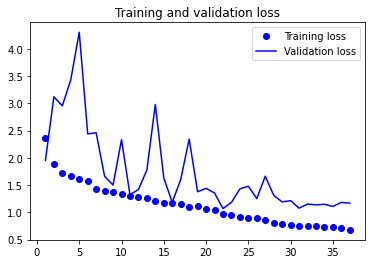

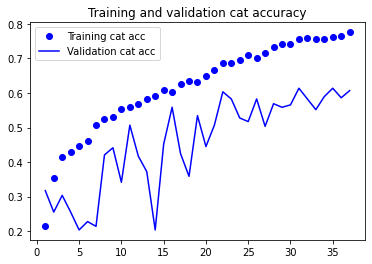

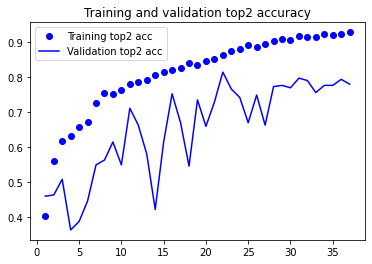

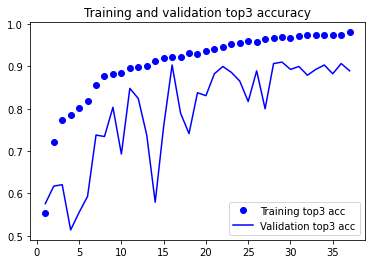

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


290/290 [==============================] - 4s 10ms/step
Confusion matrix, without normalization
[[23  5  4  5 12  1  0]
 [ 7 37  2  1  0  3  0]
 [ 4  5 16  1  6 18  0]
 [ 1  1  0  7  0 11  0]
 [ 3  4  3  1 28 11  0]
 [ 0  0  0  0  0 50  0]
 [ 0  2  0  0  0  1 17]]
              precision    recall  f1-score   support

       akiec       0.61      0.46      0.52        50
         bcc       0.69      0.74      0.71        50
         bkl       0.64      0.32      0.43        50
          df       0.47      0.35      0.40        20
         mel       0.61      0.56      0.58        50
          nv       0.53      1.00      0.69        50
        vasc       1.00      0.85      0.92        20

    accuracy                           0.61       290
   macro avg       0.65      0.61      0.61       290
weighted avg       0.63      0.61      0.60       290



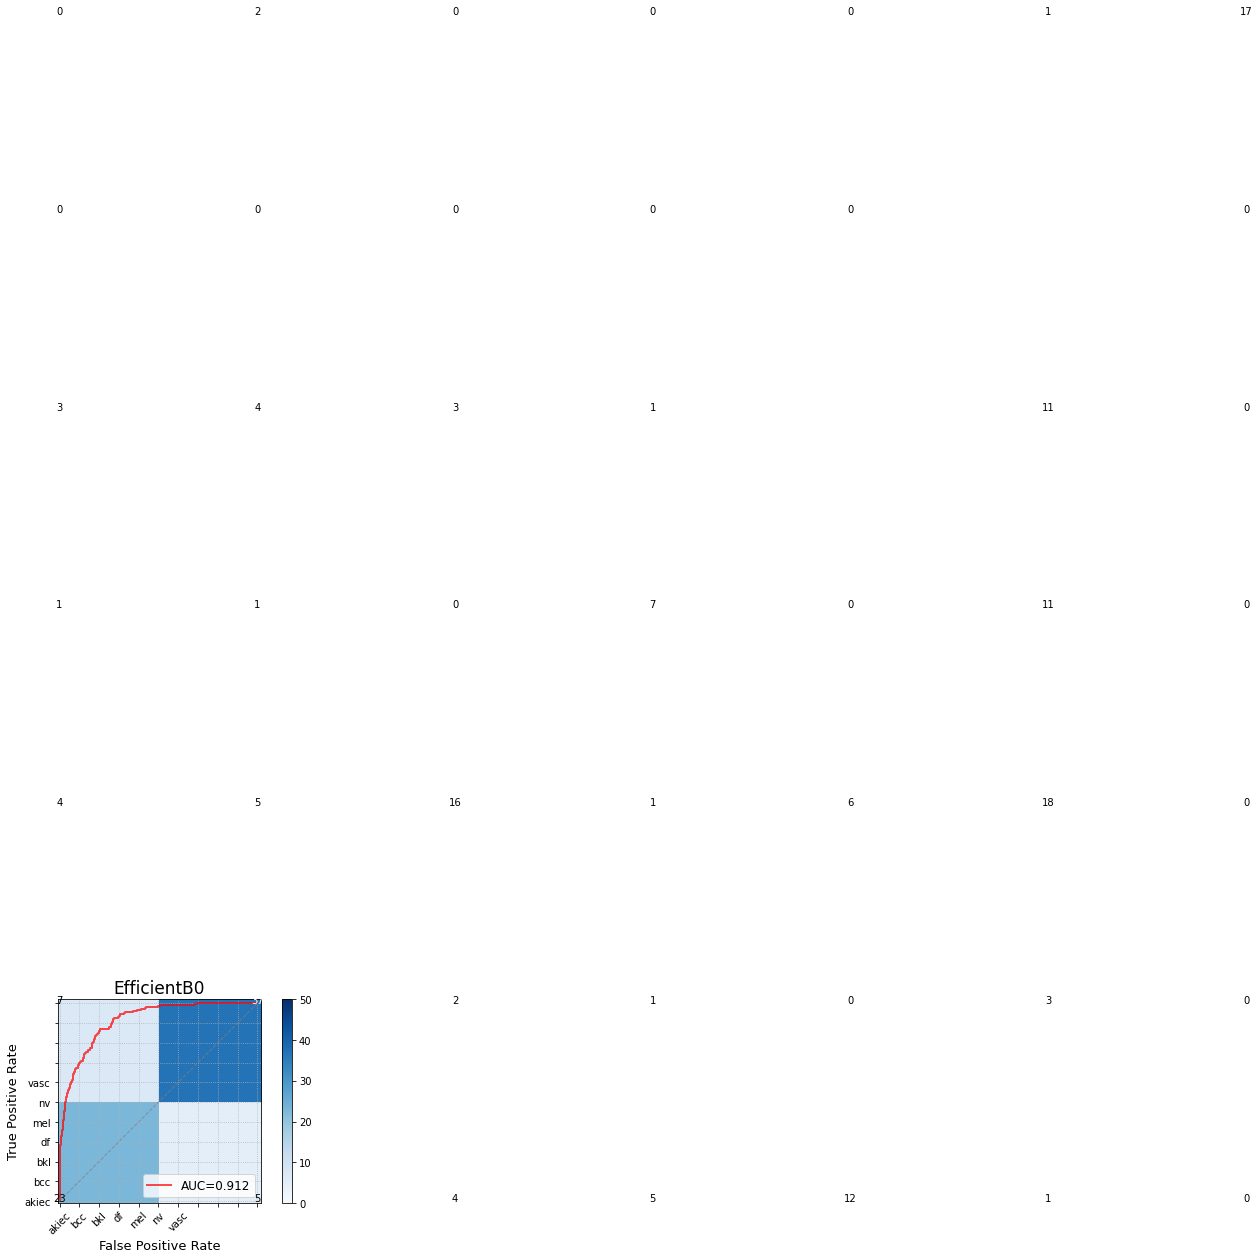

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


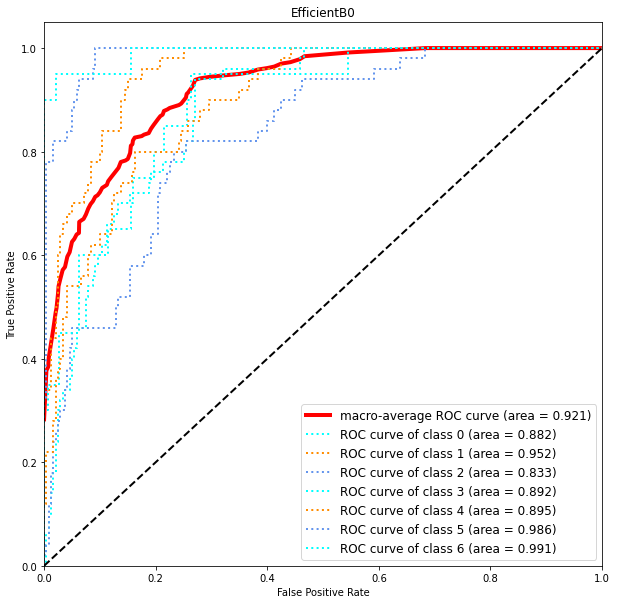

In [ ]:
EfficientB0_structure(image_height=224,image_width=224,es_patience=15,lr_patience=5,min_learningrate=0.0000001,epochs_num=200)

Found 40453 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Epoch 1/200
973/973 [==============================] - 77s 71ms/step - loss: 2.1276 - categorical_accuracy: 0.3046 - top_2_accuracy: 0.5059 - top_3_accuracy: 0.6617 - val_loss: 2.8865 - val_categorical_accuracy: 0.2586 - val_top_2_accuracy: 0.3414 - val_top_3_accuracy: 0.5655

Epoch 00001: val_categorical_accuracy improved from -inf to 0.25862, saving model to model_EB0.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
973/973 [==============================] - 69s 70ms/step - loss: 1.7572 - categorical_accuracy: 0.4124 - top_2_accuracy: 0.6275 - top_3_accuracy: 0.7826 - val_loss: 2.6930 - val_categorical_accuracy: 0.2724 - val_top_2_accuracy: 0.4310 - val_top_3_accuracy: 0.6345

Epoch 00002: val_categorical_accuracy improved from 0.25862 to 0.27241, saving model to model_EB0.h5
Epoch 3/200
973/973 [==============================] - 67s 69ms/step - loss: 1.6561 - categorical_accuracy: 0.4456 - top_2_accuracy: 0.6698 - top_3_accuracy: 0.8096 - val_loss: 2.9580 - val_categorical_accuracy: 0.1931 - val_top_2_accuracy: 0.3897 - val_top_3_accuracy: 0.6276

Epoch 00003: val_categorical_accuracy did not improve from 0.27241
Epoch 4/200
973/973 [==============================] - 67s 69ms/step - loss: 1.6135 - categorical_accuracy: 0.4604 - top_2_accuracy: 0.6793 - top_3_accuracy: 0.8249 - val_loss: 2.4200 - val_categorical_accuracy: 0.2310 - val_top_2_accuracy: 0.4414 - val_top_3_accuracy: 0.6379

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 1.030030608177185
val_cat_acc: 0.6482758522033691
val_top_2_acc: 0.8137931227684021
val_top_3_acc: 0.9241379499435425
val_loss: 1.0660253763198853
val_cat_acc: 0.6724137663841248
val_top_2_acc: 0.800000011920929
val_top_3_acc: 0.9034482836723328


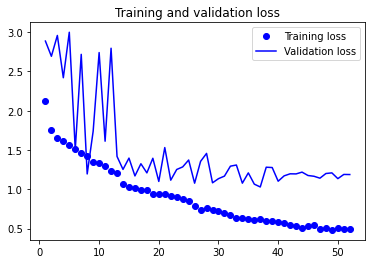

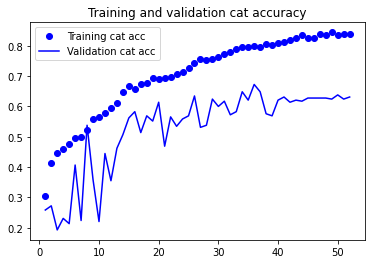

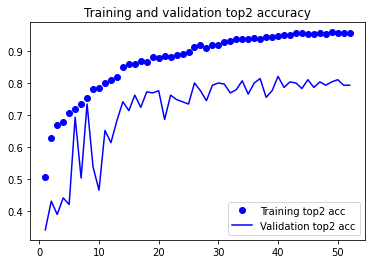

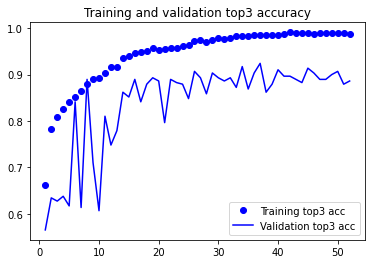

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


290/290 [==============================] - 4s 10ms/step
Confusion matrix, without normalization
[[24  8  6  0 11  1  0]
 [ 5 35  1  1  3  4  1]
 [ 4  0 27  1  5 13  0]
 [ 0  2  1  8  1  8  0]
 [ 2  3  2  0 32 11  0]
 [ 0  0  0  0  1 49  0]
 [ 0  0  0  0  0  0 20]]
              precision    recall  f1-score   support

       akiec       0.69      0.48      0.56        50
         bcc       0.73      0.70      0.71        50
         bkl       0.73      0.54      0.62        50
          df       0.80      0.40      0.53        20
         mel       0.60      0.64      0.62        50
          nv       0.57      0.98      0.72        50
        vasc       0.95      1.00      0.98        20

    accuracy                           0.67       290
   macro avg       0.72      0.68      0.68       290
weighted avg       0.69      0.67      0.66       290



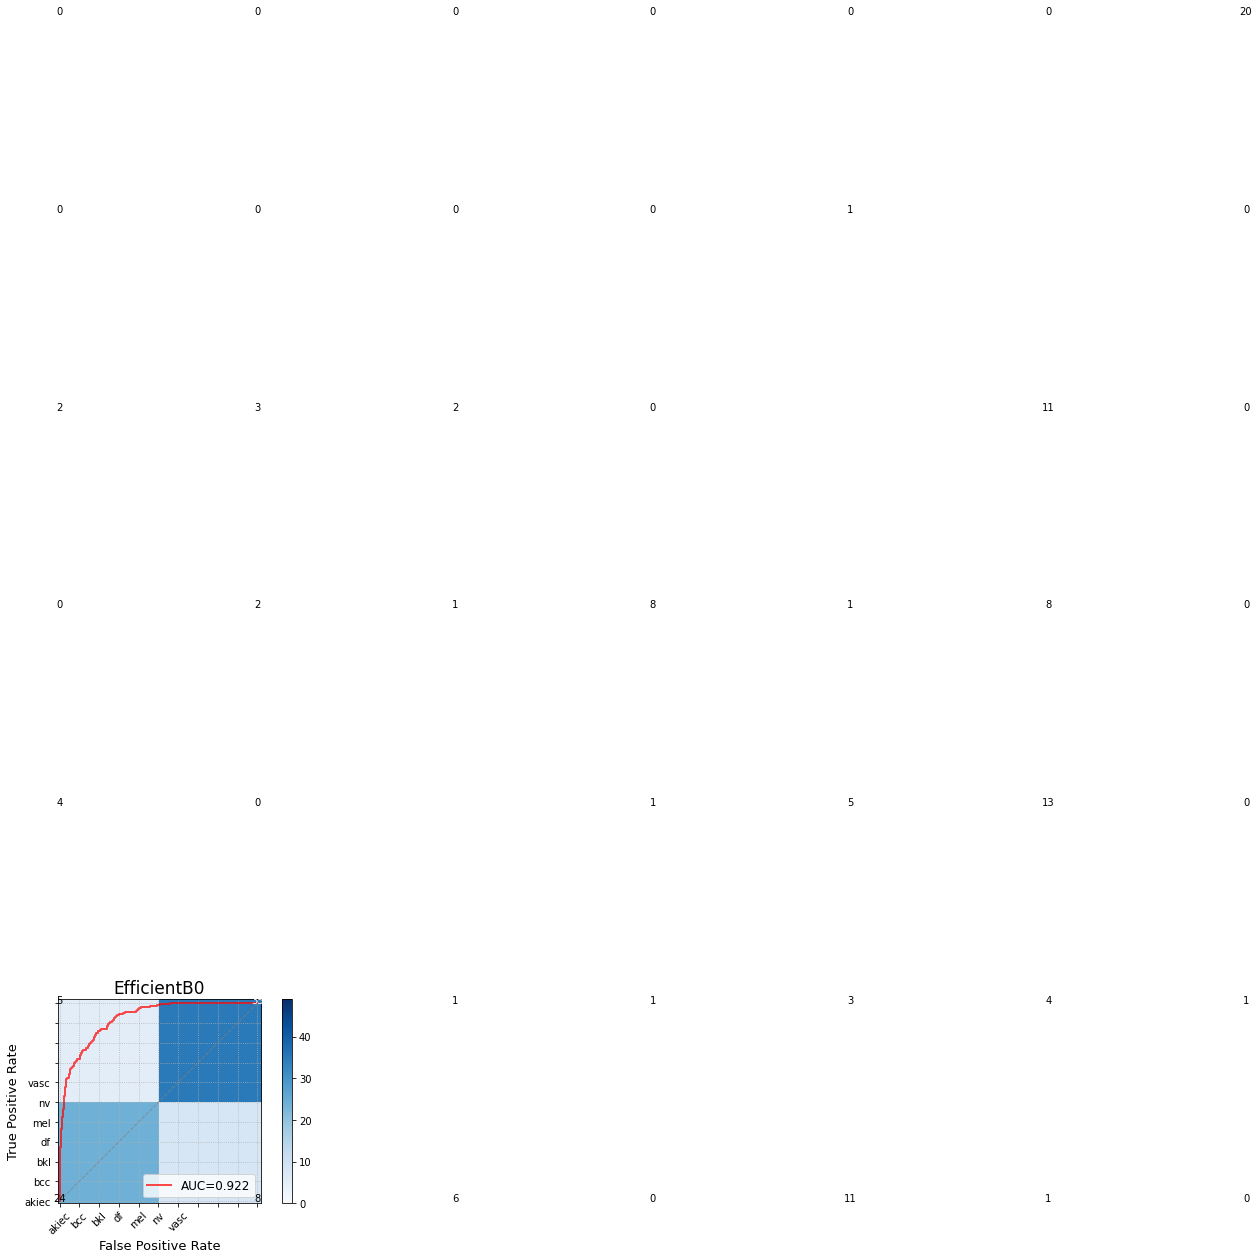

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


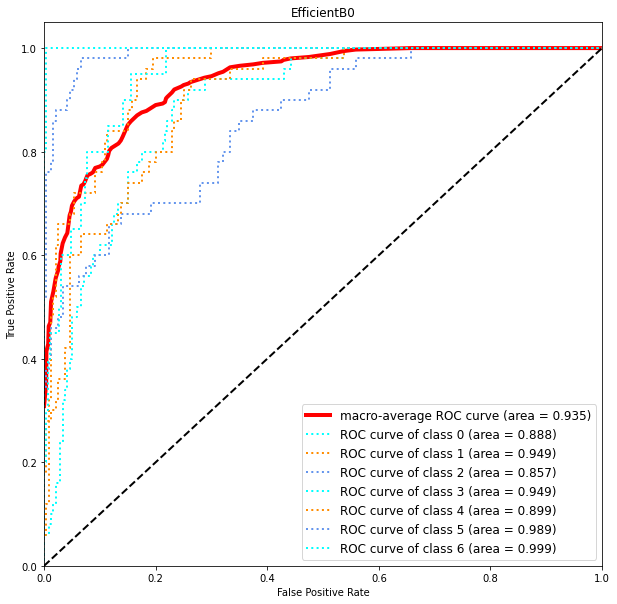

In [ ]:
EfficientB0_structure(image_height=224,image_width=224,es_patience=15,lr_patience=5,min_learningrate=0.0000001,epochs_num=200)

Found 40453 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Epoch 1/200
973/973 [==============================] - 76s 70ms/step - loss: 2.1159 - categorical_accuracy: 0.3126 - top_2_accuracy: 0.5072 - top_3_accuracy: 0.6616 - val_loss: 3.2331 - val_categorical_accuracy: 0.2828 - val_top_2_accuracy: 0.4517 - val_top_3_accuracy: 0.5621

Epoch 00001: val_categorical_accuracy improved from -inf to 0.28276, saving model to model_EB0.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
973/973 [==============================] - 68s 70ms/step - loss: 1.6863 - categorical_accuracy: 0.4266 - top_2_accuracy: 0.6414 - top_3_accuracy: 0.7892 - val_loss: 2.0575 - val_categorical_accuracy: 0.3034 - val_top_2_accuracy: 0.4862 - val_top_3_accuracy: 0.6414

Epoch 00002: val_categorical_accuracy improved from 0.28276 to 0.30345, saving model to model_EB0.h5
Epoch 3/200
973/973 [==============================] - 68s 69ms/step - loss: 1.5791 - categorical_accuracy: 0.4748 - top_2_accuracy: 0.6871 - top_3_accuracy: 0.8225 - val_loss: 2.5440 - val_categorical_accuracy: 0.2241 - val_top_2_accuracy: 0.4345 - val_top_3_accuracy: 0.6207

Epoch 00003: val_categorical_accuracy did not improve from 0.30345
Epoch 4/200
973/973 [==============================] - 66s 68ms/step - loss: 1.5804 - categorical_accuracy: 0.4811 - top_2_accuracy: 0.6881 - top_3_accuracy: 0.8275 - val_loss: 1.7425 - val_categorical_accuracy: 0.2793 - val_top_2_accuracy: 0.5621 - val_top_3_accuracy: 0.7793

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 1.0139371156692505
val_cat_acc: 0.6586207151412964
val_top_2_acc: 0.8517241477966309
val_top_3_acc: 0.9103448390960693
val_loss: 1.089812994003296
val_cat_acc: 0.6724137663841248
val_top_2_acc: 0.817241370677948
val_top_3_acc: 0.8999999761581421


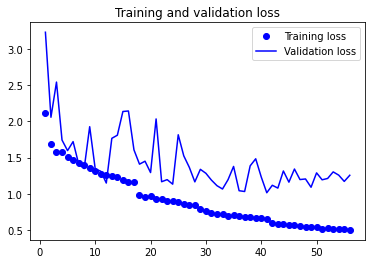

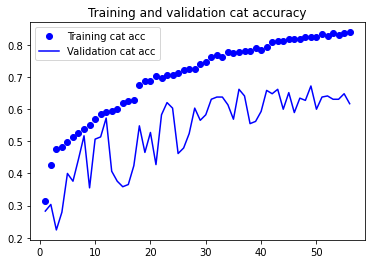

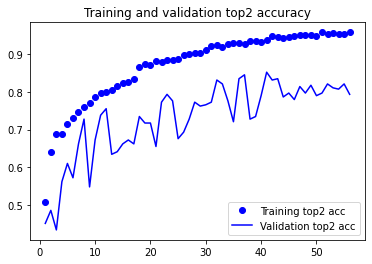

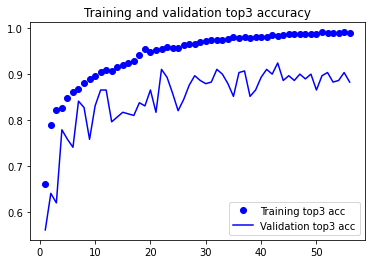

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


290/290 [==============================] - 4s 10ms/step
Confusion matrix, without normalization
[[23  6  9  0  7  5  0]
 [ 6 37  3  0  2  1  1]
 [ 3  0 27  0  7 13  0]
 [ 0  3  2  6  1  7  1]
 [ 1  1  4  0 34 10  0]
 [ 0  0  0  0  0 50  0]
 [ 0  0  0  0  0  2 18]]
              precision    recall  f1-score   support

       akiec       0.70      0.46      0.55        50
         bcc       0.79      0.74      0.76        50
         bkl       0.60      0.54      0.57        50
          df       1.00      0.30      0.46        20
         mel       0.67      0.68      0.67        50
          nv       0.57      1.00      0.72        50
        vasc       0.90      0.90      0.90        20

    accuracy                           0.67       290
   macro avg       0.75      0.66      0.66       290
weighted avg       0.70      0.67      0.66       290



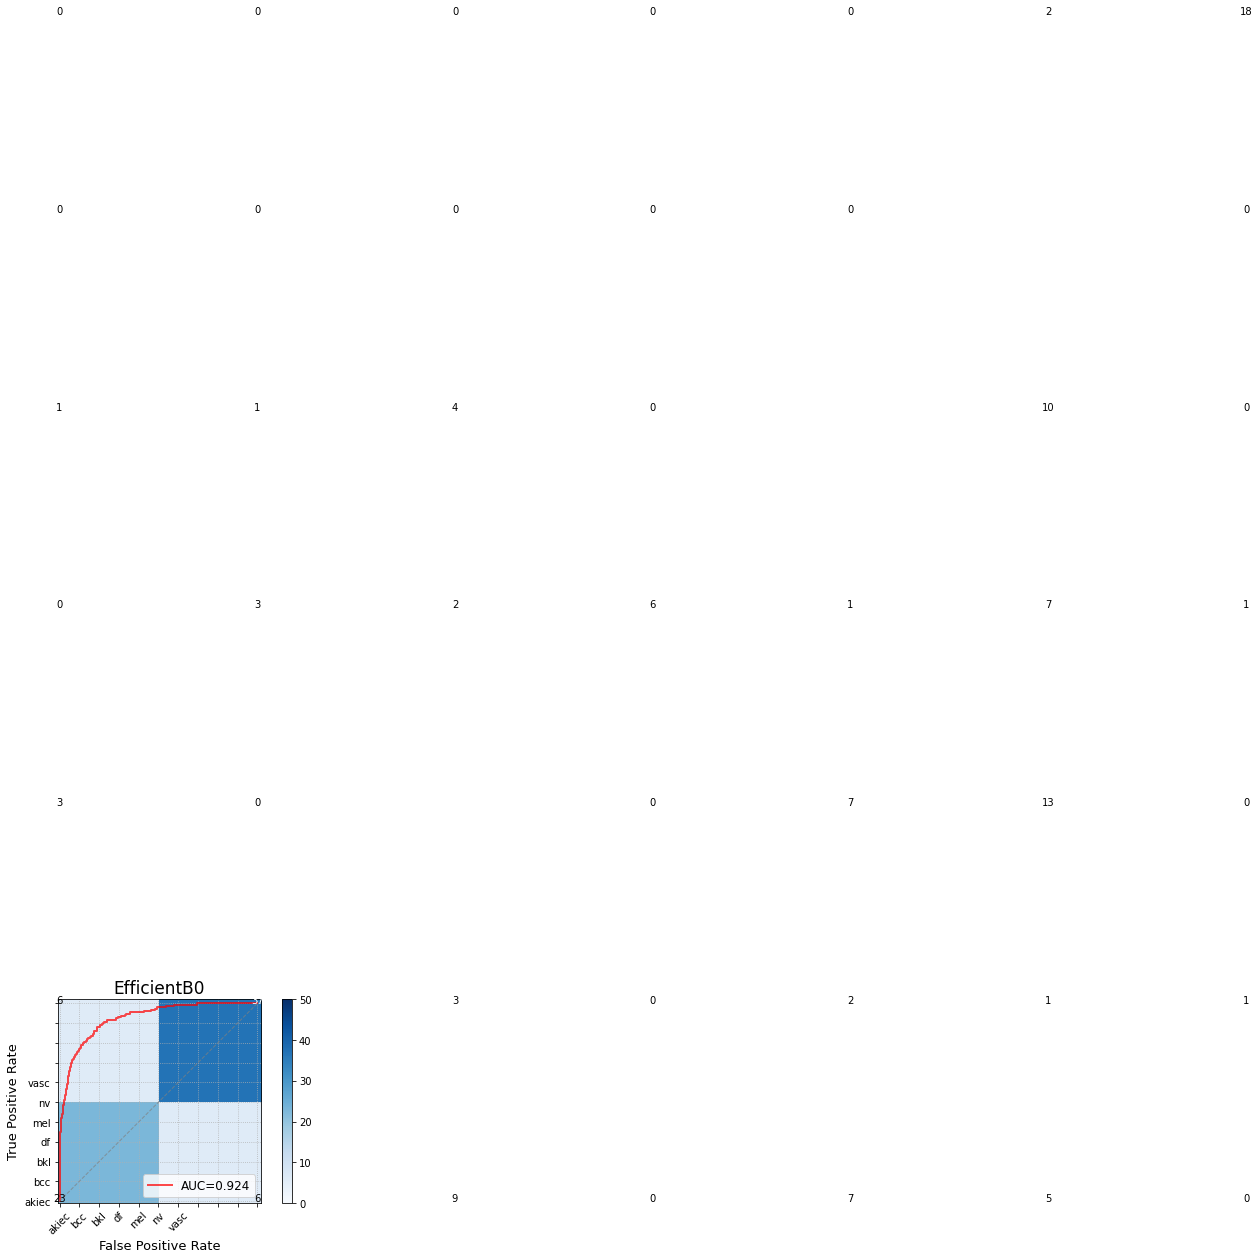

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


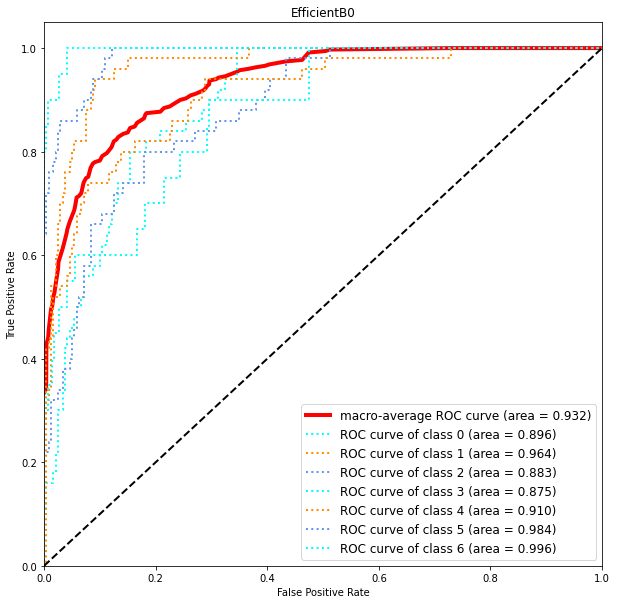

In [ ]:
EfficientB0_structure(image_height=224,image_width=224,es_patience=15,lr_patience=5,min_learningrate=0.0000001,epochs_num=200)

Found 40453 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
21848064/21834768 [==============================] - 1s 0us/step
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Epoch 1/200
973/973 [==============================] - 94s 71ms/step - loss: 1.9929 - categorical_accuracy: 0.3507 - top_2_accuracy: 0.5492 - top_3_accuracy: 0.7055 - val_loss: 2.4019 - val_categorical_accuracy: 0.2897 - val_top_2_accuracy: 0.5552 - val_top_3_accuracy: 0.7345

Epoch 00001: val_categorical_accuracy improved from -inf to 0.28966, saving model to model_EB0.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
973/973 [==============================] - 67s 69ms/step - loss: 1.6870 - categorical_accuracy: 0.4391 - top_2_accuracy: 0.6521 - top_3_accuracy: 0.7946 - val_loss: 1.6697 - val_categorical_accuracy: 0.3655 - val_top_2_accuracy: 0.5690 - val_top_3_accuracy: 0.7793

Epoch 00002: val_categorical_accuracy improved from 0.28966 to 0.36552, saving model to model_EB0.h5
Epoch 3/200
973/973 [==============================] - 68s 70ms/step - loss: 1.5703 - categorical_accuracy: 0.4838 - top_2_accuracy: 0.6952 - top_3_accuracy: 0.8286 - val_loss: 2.0928 - val_categorical_accuracy: 0.2586 - val_top_2_accuracy: 0.4966 - val_top_3_accuracy: 0.6759

Epoch 00003: val_categorical_accuracy did not improve from 0.36552
Epoch 4/200
973/973 [==============================] - 66s 67ms/step - loss: 1.5152 - categorical_accuracy: 0.4970 - top_2_accuracy: 0.7177 - top_3_accuracy: 0.8496 - val_loss: 1.9111 - val_categorical_accuracy: 0.3276 - val_top_2_accuracy: 0.5310 - val_top_3_accuracy: 0.7207

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.9316345453262329
val_cat_acc: 0.6275861859321594
val_top_2_acc: 0.8413792848587036
val_top_3_acc: 0.9379310607910156
val_loss: 1.0719356536865234
val_cat_acc: 0.634482741355896
val_top_2_acc: 0.8034482598304749
val_top_3_acc: 0.9103448390960693


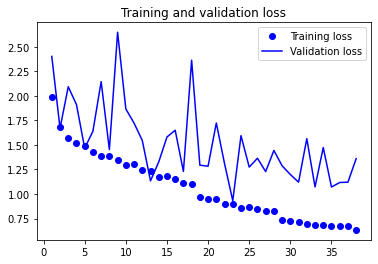

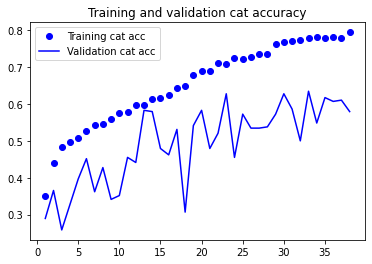

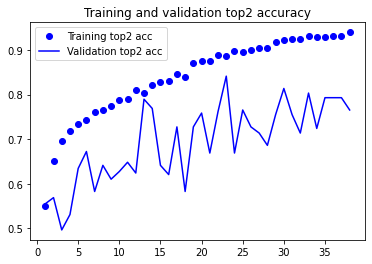

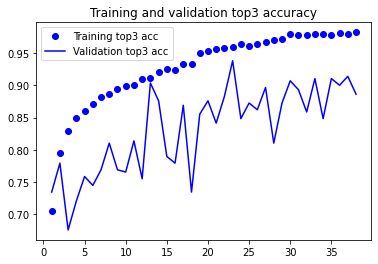

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


290/290 [==============================] - 4s 10ms/step
Confusion matrix, without normalization
[[15  8 10  0 15  2  0]
 [ 2 40  2  1  4  1  0]
 [ 1  2 27  1  6 13  0]
 [ 0  1  1  7  2  9  0]
 [ 1  2  7  0 31  9  0]
 [ 0  0  1  0  1 48  0]
 [ 0  0  0  0  0  4 16]]
              precision    recall  f1-score   support

       akiec       0.79      0.30      0.43        50
         bcc       0.75      0.80      0.78        50
         bkl       0.56      0.54      0.55        50
          df       0.78      0.35      0.48        20
         mel       0.53      0.62      0.57        50
          nv       0.56      0.96      0.71        50
        vasc       1.00      0.80      0.89        20

    accuracy                           0.63       290
   macro avg       0.71      0.62      0.63       290
weighted avg       0.67      0.63      0.62       290



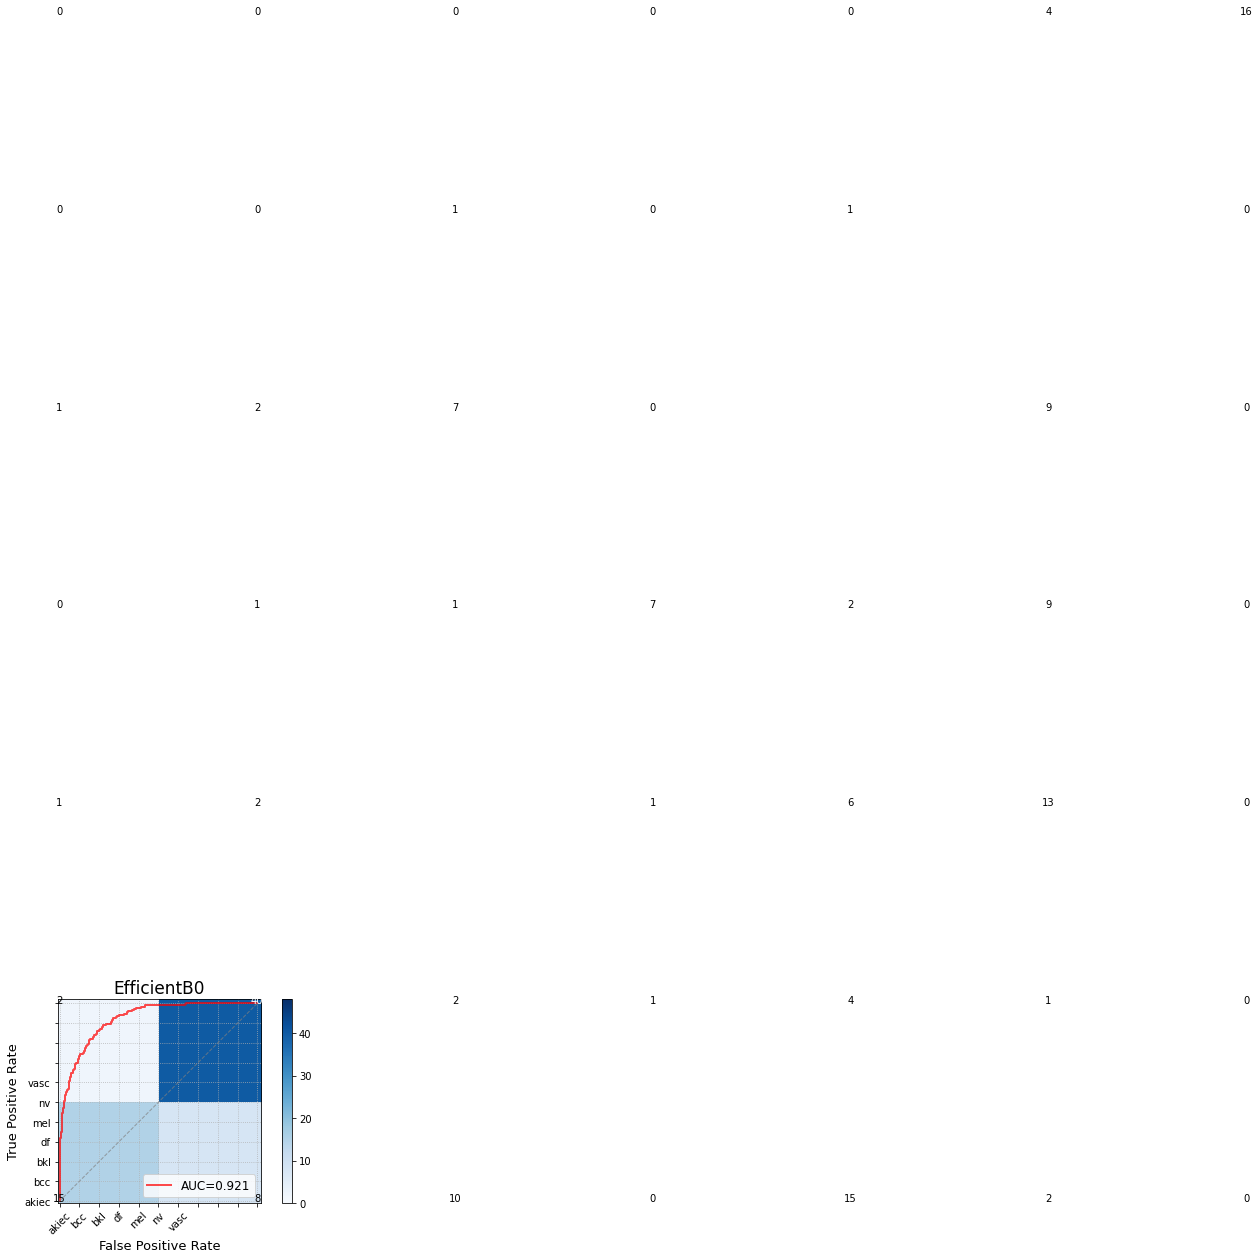

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


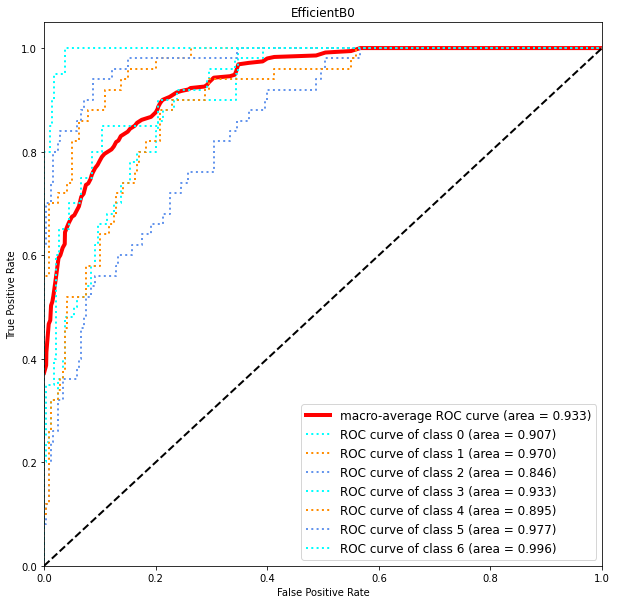

In [ ]:
EfficientB0_structure(image_height=224,image_width=224,es_patience=15,lr_patience=5,min_learningrate=0.0000001,epochs_num=200)

# **b3**

## def **model**

In [ ]:
def EfficientB3_structure(image_height,image_width,es_patience,lr_patience,min_learningrate,epochs_num):
  train_path = '/content/base_dir/train_dir'
  valid_path = '/content/base_dir/val_dir'

  num_train_samples = len(df_train)
  num_val_samples = len(df_val)
  train_batch_size = 10
  val_batch_size = 10
  # image_height = 225
  # image_width = 300

  train_steps = np.ceil(num_train_samples / train_batch_size)
  val_steps = np.ceil(num_val_samples / val_batch_size)

  ####################################################################
  datagen = ImageDataGenerator(
      preprocessing_function= \
      tf.keras.applications.efficientnet.preprocess_input)

  train_batches = datagen.flow_from_directory(train_path,
                                              target_size=(image_height,image_width),
                                              batch_size=train_batch_size)

  valid_batches = datagen.flow_from_directory(valid_path,
                                              target_size=(image_height,image_width),
                                              batch_size=val_batch_size)

  # Note: shuffle=False causes the test dataset to not be shuffled
  test_batches = datagen.flow_from_directory(valid_path,
                                              target_size=(image_height,image_width),
                                              batch_size=1,
                                              shuffle=False)
  #####################################################################
  # create a copy of a mobilenet model
  model_EB0 = tf.keras.applications.efficientnet.EfficientNetB3()
  # model_EB0.summary()
  # CREATE THE MODEL ARCHITECTURE

  # This will include all layers up to and including global_average_pooling2d_1
  x = model_EB0.layers[-3].output

  # Create a new dense layer for predictions
  # 7 corresponds to the number of classes
  x = Dropout(0.25)(x)
  predictions = Dense(7, activation='softmax')(x)

  # inputs=mobile.input selects the input layer, outputs=predictions refers to the dense layer we created above.

  model_EB0 = Model(inputs=model_EB0.input, outputs=predictions)

  # model_EB0.summary()
  #######################################################################
  # Get the labels that are associated with each index
  print(valid_batches.class_indices)


  # Add weights to try to make the model more sensitive to melanoma

  class_weights={
      0: 1.0, # akiec
      1: 1.0, # bcc
      2: 1.0, # bkl
      3: 1.0, # df
      4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
      5: 1.0, # nv
      6: 1.0, # vasc
  }
  #######################################################################
  model_EB0.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', 
                metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

  filepath = "model_EB0.h5" #inceptionV3
  checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                              save_best_only=True, mode='max')

  es_callback = tf.keras.callbacks.EarlyStopping(patience=es_patience, 
                                                verbose=1, 
                                                restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=lr_patience, 
                                    verbose=1, mode='max', min_lr=min_learningrate)
                                
                                
  callbacks_list = [es_callback,checkpoint, reduce_lr]

  history = model_EB0.fit(train_batches, steps_per_epoch=train_steps, 
                                class_weight=class_weights,
                      validation_data=valid_batches,
                      validation_steps=val_steps,
                      epochs=epochs_num, verbose=1,
                    callbacks=callbacks_list)
  ######################################################################### Evaluation
  #Draw loss figure
  # get the metric names so we can use evaulate_generator
  model_EB0.metrics_names

  # Here the the last epoch will be used.

  val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
  model_EB0.evaluate_generator(test_batches, 
                          steps=len(df_val))

  print('val_loss:', val_loss)
  print('val_cat_acc:', val_cat_acc)
  print('val_top_2_acc:', val_top_2_acc)
  print('val_top_3_acc:', val_top_3_acc)

  # Here the best epoch will be used.

  model_EB0.load_weights('model_EB0.h5')

  val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
  model_EB0.evaluate_generator(test_batches, 
                          steps=len(df_val))

  print('val_loss:', val_loss)
  print('val_cat_acc:', val_cat_acc)
  print('val_top_2_acc:', val_top_2_acc)
  print('val_top_3_acc:', val_top_3_acc)


  # display the loss and accuracy curves

  import matplotlib.pyplot as plt

  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_top2_acc = history.history['top_2_accuracy']
  val_top2_acc = history.history['val_top_2_accuracy']
  train_top3_acc = history.history['top_3_accuracy']
  val_top3_acc = history.history['val_top_3_accuracy']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.figure()

  plt.plot(epochs, acc, 'bo', label='Training cat acc')
  plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
  plt.title('Training and validation cat accuracy')
  plt.legend()
  plt.figure()


  plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
  plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
  plt.title('Training and validation top2 accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
  plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
  plt.title('Training and validation top3 accuracy')
  plt.legend()


  plt.show()
  ######################################################################### Evaluation
  #Draw Confusion matrix

  # Get the labels of the test images.

  test_labels = test_batches.classes
  # We need these to plot the confusion matrix.
  test_labels

  # Print the label associated with each class
  test_batches.class_indices

  # make a prediction
  predictions = model_EB0.predict_generator(test_batches, steps=len(df_val), verbose=1)

  test_labels.shape
  # argmax returns the index of the max value in a row
  cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
  test_batches.class_indices

  # Define the labels of the class indices. These need to match the 
  # order shown above.
  cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

  plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
  ######################################################################### Evaluation
  # Get report
  # Get the index of the class with the highest probability score
  y_pred = np.argmax(predictions, axis=1)

  # Get the labels of the test images.
  y_true = test_batches.classes

  from sklearn.metrics import classification_report

  # Generate a classification report
  report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

  print(report)
  ######################################################################### Evaluation
  #Draw AUC
  from sklearn import metrics
  from itertools import chain
  def f(i):
    l = [0, 0, 0, 0, 0, 0, 0]
    l[i] = 1
    return l
  #计算
  y_pre = list(map(f,test_batches.classes))
  y = sum(y_pre,[])
  scores = list(chain.from_iterable(predictions))

  fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)

  from sklearn.metrics import auc 
  metrics.auc(fpr, tpr) 
  auc = metrics.auc(fpr, tpr)
  #image drawing
  plt.plot(fpr, tpr, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % auc)
  plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
  plt.xlim((-0.01, 1.02))
  plt.ylim((-0.01, 1.02))
  plt.xticks(np.arange(0, 1.1, 0.1))
  plt.yticks(np.arange(0, 1.1, 0.1))
  plt.xlabel('False Positive Rate', fontsize=13)
  plt.ylabel('True Positive Rate', fontsize=13)
  plt.grid(b=True, ls=':')
  plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
  plt.title(u'EfficientB0', fontsize=17)
  plt.show()

  # 引入必要的库
  import matplotlib.pyplot as plt
  from itertools import cycle
  from sklearn import svm, datasets
  from sklearn.metrics import roc_curve, auc
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import label_binarize
  from sklearn.multiclass import OneVsRestClassifier
  from scipy import interp

  yscore = predictions.tolist()


  # 计算每一类的ROC
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(cm_plot_labels)):
      fpr[i], tpr[i], thresholds = metrics.roc_curve([m[i] for m in y_pre], [n[i] for n in yscore], pos_label=1)
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute macro-average ROC curve and ROC area（方法一）
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(cm_plot_labels))]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(len(cm_plot_labels)):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])
  # Finally average it and compute AUC
  mean_tpr /= len(cm_plot_labels)
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


  # Plot all ROC curves
  lw=2
  plt.figure(figsize=(10,10))


  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
          color='r',  linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(len(cm_plot_labels)), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,linestyle=':',
              label='ROC curve of class {0} (area = {1:0.3f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('EfficientB0')
  plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
  plt.show()

## **Train&Get result**

Found 39887 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Epoch 1/300
246/246 [==============================] - 63s 199ms/step - loss: 2.5603 - categorical_accuracy: 0.1720 - top_2_accuracy: 0.3337 - top_3_accuracy: 0.4898 - val_loss: 44.1143 - val_categorical_accuracy: 0.1828 - val_top_2_accuracy: 0.2690 - val_top_3_accuracy: 0.4207

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18276, saving model to model_EB0.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
246/246 [==============================] - 47s 190ms/step - loss: 2.2665 - categorical_accuracy: 0.2126 - top_2_accuracy: 0.4142 - top_3_accuracy: 0.5707 - val_loss: 22.2096 - val_categorical_accuracy: 0.1345 - val_top_2_accuracy: 0.2276 - val_top_3_accuracy: 0.3379

Epoch 00002: val_categorical_accuracy did not improve from 0.18276
Epoch 3/300
246/246 [==============================] - 47s 190ms/step - loss: 2.1512 - categorical_accuracy: 0.2642 - top_2_accuracy: 0.4650 - top_3_accuracy: 0.6325 - val_loss: 7.4243 - val_categorical_accuracy: 0.1621 - val_top_2_accuracy: 0.3448 - val_top_3_accuracy: 0.5034

Epoch 00003: val_categorical_accuracy did not improve from 0.18276
Epoch 4/300
246/246 [==============================] - 47s 190ms/step - loss: 2.0196 - categorical_accuracy: 0.3215 - top_2_accuracy: 0.5244 - top_3_accuracy: 0.6821 - val_loss: 2.0078 - val_categorical_accuracy: 0.2345 - val_top_2_accuracy: 0.3448 - val_top_3_accuracy: 0.5379

Epoch 00004: val_categorical

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 1.265130639076233
val_cat_acc: 0.5
val_top_2_acc: 0.748275876045227
val_top_3_acc: 0.8586207032203674
val_loss: 1.3202807903289795
val_cat_acc: 0.5103448033332825
val_top_2_acc: 0.7206896543502808
val_top_3_acc: 0.9068965315818787


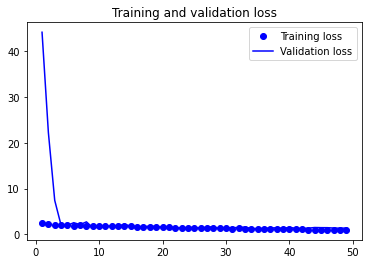

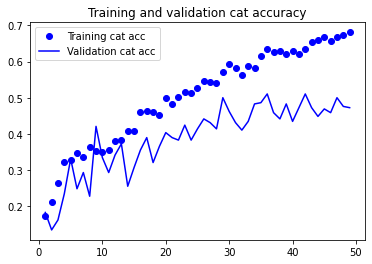

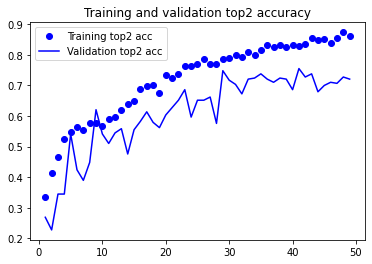

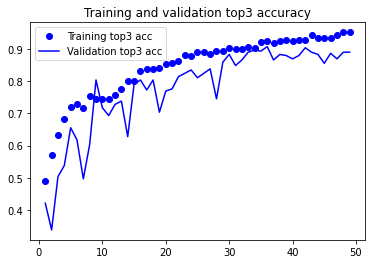

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


290/290 [==============================] - 7s 16ms/step
Confusion matrix, without normalization
[[ 7 14  3  1 24  1  0]
 [ 3 34  1  6  4  1  1]
 [ 2  3 13  2 19 10  1]
 [ 0  1  1 17  1  0  0]
 [ 1  4  6  2 33  4  0]
 [ 0  3 10  3  9 25  0]
 [ 0  1  0  0  0  0 19]]
              precision    recall  f1-score   support

       akiec       0.54      0.14      0.22        50
         bcc       0.57      0.68      0.62        50
         bkl       0.38      0.26      0.31        50
          df       0.55      0.85      0.67        20
         mel       0.37      0.66      0.47        50
          nv       0.61      0.50      0.55        50
        vasc       0.90      0.95      0.93        20

    accuracy                           0.51       290
   macro avg       0.56      0.58      0.54       290
weighted avg       0.53      0.51      0.48       290



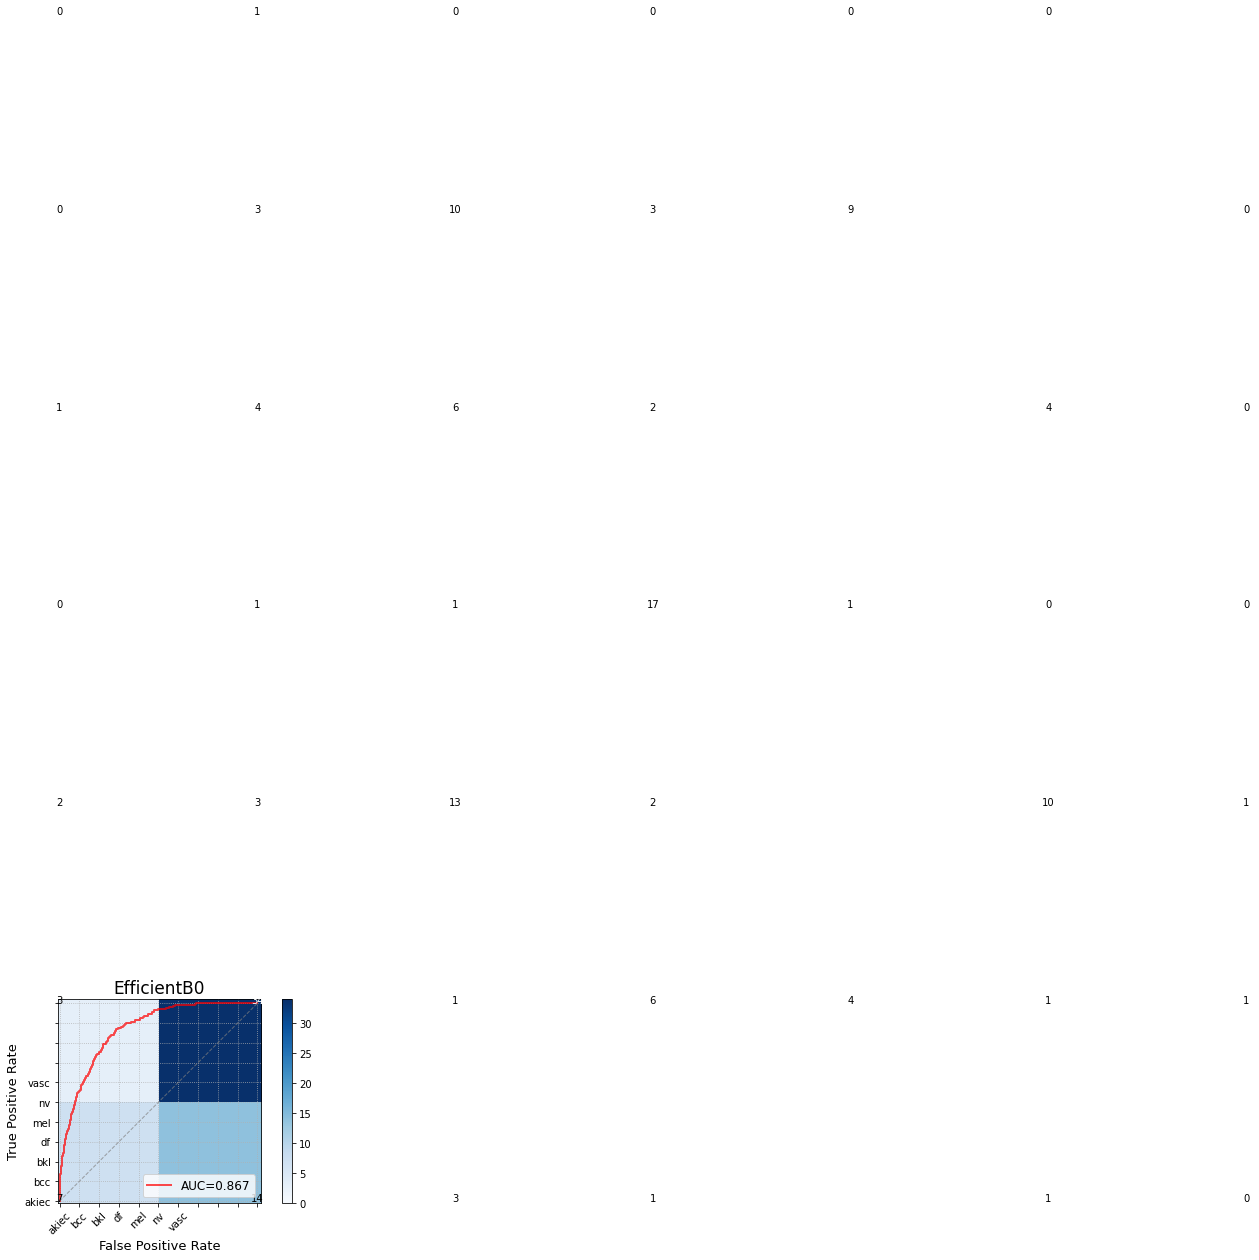

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


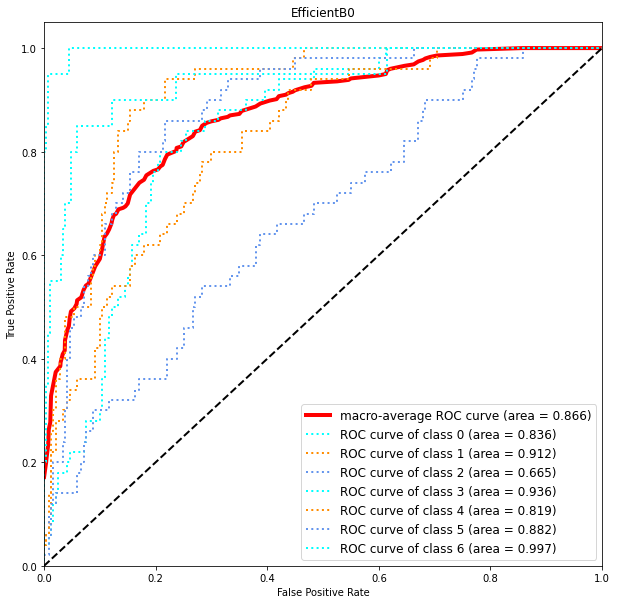

In [ ]:
# 500 sample has argumentation
EfficientB3_structure(image_height=300,image_width=300,es_patience=20,lr_patience=5,min_learningrate=0.0000001,epochs_num=300)

# **Tensorflow lite**

In [ ]:
!unzip '/content/drive/MyDrive/5703File/DataSet/dataverse_files/model_EB0.zip' -d '/content/'

Archive:  /content/drive/MyDrive/5703File/DataSet/dataverse_files/model_EB0.zip
replace /content/model_EB0.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
#Load Model 
model_EfficientB0 = keras.models.load_model('/content/model_EB0.h5', custom_objects={'categorical_accuracy': categorical_accuracy,'top_2_accuracy': top_2_accuracy,'top_3_accuracy': top_3_accuracy})

In [ ]:
# try to make a prediction 
predictions = model_EfficientB0.predict(test_batches, steps=len(df_val), verbose=1)

1103/1103 [==============================] - 29s 11ms/step


In [ ]:
predictions[0]

array([0.24588661, 0.2050323 , 0.16516887, 0.01273716, 0.00088755,
       0.34489632, 0.02539122], dtype=float32)

In [ ]:
#save model
model_EfficientB0.save("/content/model_EfficientB0")

INFO:tensorflow:Assets written to: /content/model_EfficientB0/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# convert model
converter = tf.lite.TFLiteConverter.from_saved_model('/content/model_EfficientB0')
tflite_model = converter.convert()
open("/content/converted_model.tflite", "wb").write(tflite_model)

************************************************************************
Test convert model
************************************************************************

In [ ]:
##choose one picture
img = cv2.imread('/content/HAM10000_images_part_1/ISIC_0024307.jpg')
img = cv2.resize(img, (224 ,224))
img = np.array(img, dtype="float32")
img = np.reshape(img, (1,224,224,3))

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='/content/converted_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

print("*"*50, input_details)
interpreter.set_tensor(input_details[0]['index'], img)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

************************************************** [{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[3.1031541e-06 3.6106812e-04 8.8327369e-03 1.1285768e-03 4.1629869e-04
  1.3486953e-01 8.5438871e-01]]


In [ ]:
output_data

array([[3.1031541e-06, 3.6106812e-04, 8.8327369e-03, 1.1285768e-03,
        4.1629869e-04, 1.3486953e-01, 8.5438871e-01]], dtype=float32)

In [ ]:
model_EfficientB0.predict(img)

array([[3.1031452e-06, 3.6106523e-04, 8.8326782e-03, 1.1285624e-03,
        4.1629534e-04, 1.3486871e-01, 8.5438961e-01]], dtype=float32)